# <center> Analyze and model median earnings post graduation

Prior research has attempted to model median earnings post graduation using data from the College Scorecard. [Research](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3406771) from The College Board used to estimate the effect of major composition on post graduation earnings uses explanatory variables such as: average SAT scores, admissions rates, shares of first generation, dependent, low income and Pell Grant recipients, average family income of dependent and independent students, and share of female students in the prediction of median earnings post graduation. [Other](https://arxiv.org/pdf/1803.06615.pdf) research considers features such as: institution type (i.e., public or private), degree completion rates, average faculty salary, average student age at entry, students' parents' highest level of education, and average debt.

Of special interest in this analysis are features that reflect institutional policies that can be adapted to improve student outcomes, particularly among institutions that serve a high percentage of underserved students. These features include: whether an institution has an open admissions policy and the percentage of students who have received Pell Grants. Additional features such as one-year repayment rates are considered as well in the feature selection process.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import sqlite3
import plotly.graph_objects as go
import os

import statsmodels.api as sm
from scipy.stats import normaltest
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor

import sklearn.metrics as metrics
from sklearn.metrics import r2_score, mean_squared_error
import pickle

Ingest the data used for this analysis.

In [2]:
sqlite_db = './data/analysis_data_set.sqlite'
conn = sqlite3.connect(sqlite_db)

sql = """
SELECT *
FROM analysis_data_set
"""

df = pd.read_sql(sql, con = conn)

### Exploratory data analysis

The following approach will be used to used to understand the data available:
* Explore institutional characteristics such as location, type, and open admissions indicator
* Explore the distribution of key features and search for outliers
* Evaluate the relationship between these features and median earnings post graduation using Pearson correlations and data visualizations
* Select the features with the strongest relationships with median earnings post graduation based on the correlations and data visualizations

### Modeling

* Apply missing data imputation methods including simple median, K-nearest neighbor, and a multivariate imputer that will estimate missing values from all other features
* Fit multiple linear, Lasso, and Ridge regression models to select the features with the strongest relationships to the median earnings feature
* Fit additional ensemble models including Random Forest, Extra-Trees, and Gradient Boost Regression models
* Choose the model that produces the highest R-squared score with lowest standard deviations.

#### Institution locations:
Institutions across the United States are represented in the data set. States like California, New York, Texas, and Florida have among the largest numbers of institutions across the country. These are also some of the states with the highest populations. In California, in particular, the University of California system declared in May 2021 that it will not consider SAT and ACT scores in admissions and financial aid decisions, a change that is expected to increase access to underserved students, a similar goal of open admissions policies.

In [3]:
df_states = pd.DataFrame(df['stabbr'].value_counts())
df_states.reset_index(inplace=True)
df_states.rename(columns={'index':'stabbr','stabbr':'inst_cnt'}, inplace=True)

figure = go.Figure(data=go.Choropleth(
    locations=df_states['stabbr'],
    z = df_states['inst_cnt'],
    locationmode = 'USA-states',
    colorscale = 'Blues',
    colorbar_title = "Number of higher education institutions by state",
))

figure.update_layout(
    title_text = 'Higher education institution counts across U.S. in 2008-09 academic year',
    geo_scope='usa',
)

figure.show()

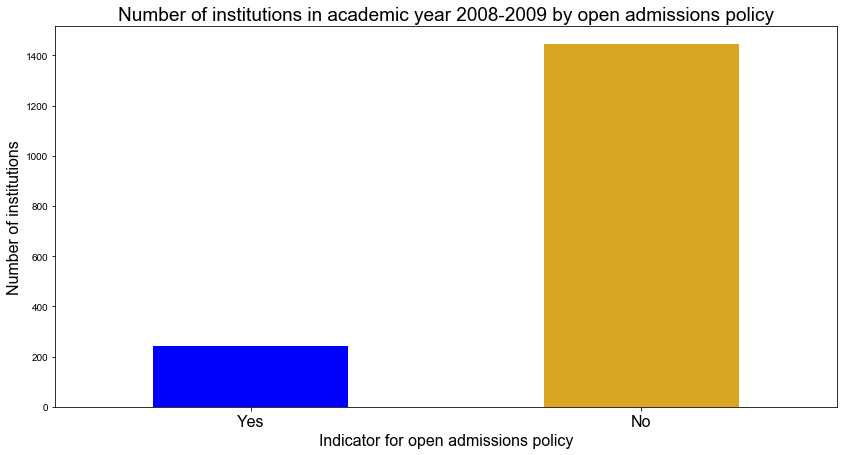

In [4]:
plt.figure(figsize=(14,7))
plot = df['openadmp'].value_counts().sort_index().plot(kind='bar', color = ['blue', 'goldenrod'])
sns.set_theme()
plt.ylabel('Number of institutions',size=16)
plt.xlabel('Indicator for open admissions policy',size=16)
plot.set_xticklabels(['Yes','No'],size=16,rotation=0)
plt.title('Number of institutions in academic year 2008-2009 by open admissions policy',size=19);

Most institutions did not have an open admissions policy in academic year 2008-2009.

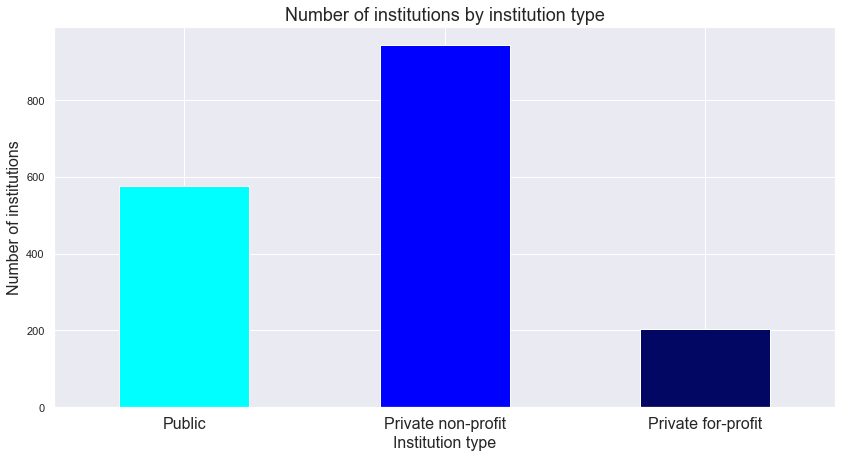

In [5]:
plt.figure(figsize=(14,7))
plot = df['control'].value_counts().sort_index().plot(kind='bar', color = ['#00FFFF','#0000FF','#030764'])
plt.ylabel('Number of institutions',size=16)
plt.xlabel('Institution type',size=16)
plot.set_xticklabels(['Public','Private non-profit', 'Private for-profit'],size=16, rotation=0)
plt.title('Number of institutions by institution type',size=18);

Most of the institutions represented in the data set are private non-profit institutions followed by public institutions. Priavte for-profit institutions are the least common type of institution in the data set.

In [6]:
df['preddeg'].map({1:'Certificate',2:'Associate''s',3:'Bachelor''s',4:'Graduate'}).value_counts(normalize=True)

Bachelors      0.872316
Associates     0.109112
Certificate    0.012768
Graduate       0.005804
Name: preddeg, dtype: float64

87% of institutions predominantly awarded Bachelor's degrees followed by institutions whose predominant degree awarded was an Associate's degree (10.8%). The remaining institutions' predominant degrees awarded were a Graduate or a Certificate degree.

In [7]:
df.loc[df['ccbasic'] == -3, 'ccbasic'] = 0

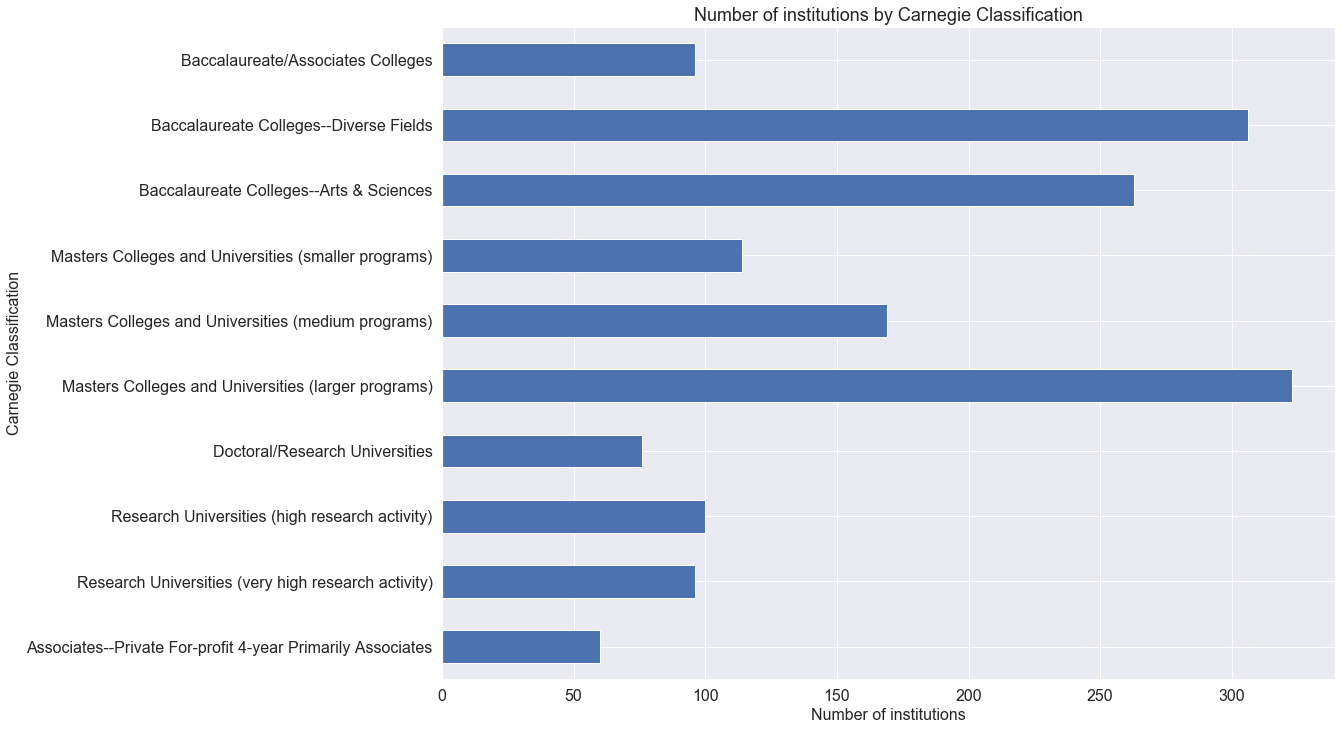

In [8]:
plt.figure(figsize=(16,12))
plot = df[df['ccbasic']>=14]['ccbasic'].value_counts().sort_index().plot(kind='barh')

labels = ['Associate''s--Private For-profit 4-year Primarily Associate''s','Research Universities (very high research activity)',
          'Research Universities (high research activity)','Doctoral/Research Universities','Master''s Colleges and Universities (larger programs)',
          'Master''s Colleges and Universities (medium programs)','Master''s Colleges and Universities (smaller programs)',
          'Baccalaureate Colleges--Arts & Sciences','Baccalaureate Colleges--Diverse Fields','Baccalaureate/Associate''s Colleges']

plot.set_yticklabels(labels=labels,size=16)
plt.xticks(fontsize=16)

plt.title('Number of institutions by Carnegie Classification',size=18)
plt.xlabel('Number of institutions', size=16)
plt.ylabel('Carnegie Classification',size=16);

[The Carnegie Classification of Institutions of Higher Education](https://carnegieclassifications.iu.edu/downloads.php) is a widely used categorization of higher education institutions based on characteristics such as enrollment size and level of research activity. The most common type of institution in the data set includes Masters' level Colleges and Universities that are larger programs, followed by institutions that award Baccalaureate Colleges in diverse fields. The least common type of institutions in the data set are Associate's level institutions.

### Explore the median earnings post graduation feature.

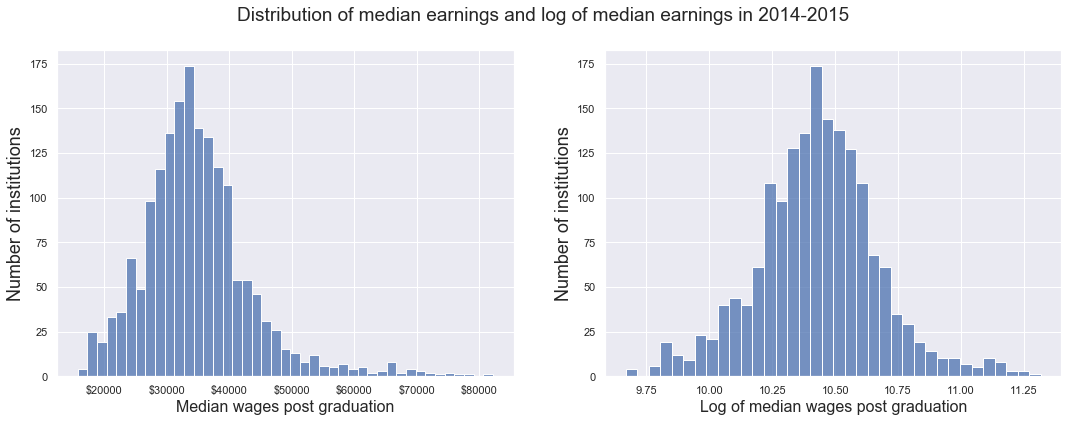

In [9]:
fig, axes = plt.subplots(1,2, figsize=(18,6))
sns.set_theme()
ax0 = sns.histplot(data = df, x = 'md_earn_wne_p6', ax=axes[0])
ax1 = sns.histplot(data = df, x = np.log(df['md_earn_wne_p6']), ax=axes[1])

formatter = ticker.FormatStrFormatter('$%1.0f')
ax0.xaxis.set_major_formatter(formatter)

ax0.set_xlabel('Median wages post graduation', size=16)
ax1.set_xlabel('Log of median wages post graduation', size=16)
ax0.set_ylabel('Number of institutions', size=18)
ax1.set_ylabel('Number of institutions', size=18)

fig.suptitle('Distribution of median earnings and log of median earnings in 2014-2015',size = 19);
plt.savefig('./assets/earnings.png')

The median earnings six-years post graduation appears to have a roughly normal distribution. However, this feature has high variability ranging from less than \\$20,000 to over \\$80,000, which can be smoothed by using a log transformation of this feature. The log transformation is closer to a normal distribution. This distribution can be more easily modeled and will be used as the target for this analysis.

In [10]:
df['log_earnings'] = np.log(df['md_earn_wne_p6'])

Identify outliers as institutions that have a log median earnings value that is three standard deviations within the mean. From the output below, it appears that well-known institutions such as MIT, Duke, Harvard University, among others have high median earnings. This may be expected given the academic quality of these institutions. Institutions such as Allen University and Plaza College have very low median earnings and can be deleted from the data set.

In [11]:
df[(df.log_earnings < np.mean(df['log_earnings']) - 3 * np.std(df['log_earnings'])) | \
   (df.log_earnings > np.mean(df['log_earnings']) + 3 * np.std(df['log_earnings']))]\
    [['instnm','unitid','md_earn_wne_p6','log_earnings']].sort_values(by='md_earn_wne_p6')

instnm  unitid  \
1370                     Southwestern Christian College  228486   
1244                                   Allen University  217624   
164                                   Naropa University  127653   
903                                       Plaza College  194499   
582                                  Harvard University  166027   
1539                                Stanford University  243744   
1617                                    Miami Ad School  428000   
1205                         University of Pennsylvania  215062   
106                                 Harvey Mudd College  115409   
95         California State University Maritime Academy  111188   
1665                  West Coast University-Los Angeles  443331   
526                              Maine Maritime Academy  161299   
969                                     Duke University  198419   
1633  Louisiana State University Health Sciences Cen...  435000   
589               Massachusetts Institute of Technology  166683   

      md_earn_wne_p6  log_earnings  
1370         15800.0      9.667765  
1244         15900.0      9.674074  
164          16300.0      9.698920  
903          16300.0      9.698920  
582          70300.0     11.160527  
1539         70400.0     11.161949  
1617         70900.0     11.169026  
1205         71600.0     11.178850  
106          72500.0     11.191342  
95           73100.0     11.199584  
1665         74600.0     11.219896  
526          75200.0     11.227907  
969          76300.0     11.242428  
1633         78200.0     11.267025  
589          82200.0     11.316911

In [12]:
df = df[~df['unitid'].isin([228486,217624,194499])]

The following steps will be used to explore the most relevant features in the data set:
* Visually explore the relationship between each feature and the log of median earnings
* Inspect the distribution of each feature and identify potential outliers visually
* For features that follow a normal distribution, identify outliers as observations that are within three standard deviations of the mean
* For features that do not follow a normal distribution, identify outliers as observations that are above the third quartile plus 1.5 times the interquartile range or below the first quartile minus 1.5 times the interquartile range [(Tukey's method)](https://community.ibm.com/community/user/datascience/blogs/moloy-de1/2021/03/23/points-to-ponder)

Scale features ranging from 0-1 for future use in the analysis.

In [13]:
for feature in ['dep_rpy_1yr_rt','pell_ever','ret_ft4','par_ed_pct_hs','cdr2','pell_enrl_orig_yr2_rt','c150_4']:
    df[feature] = df[feature] * 100

### One-year repayment rate for dependent students

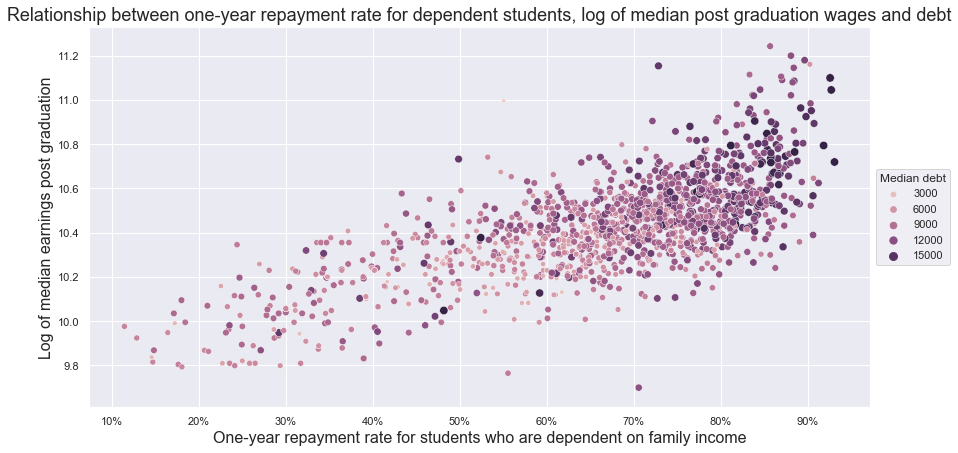

In [14]:
plt.figure(figsize=(14,7))
plot = sns.scatterplot(data=df,x='dep_rpy_1yr_rt',y='log_earnings',color="blue",size='debt_mdn',hue='debt_mdn')
sns.set_theme()
sns.color_palette("rocket", as_cmap=True)
plt.ylabel('Log of median earnings post graduation', size=16)
plt.xlabel('One-year repayment rate for students who are dependent on family income', size=16)
plt.title('Relationship between one-year repayment rate for dependent students, log of median post graduation wages and debt',
         size = 18)
plt.legend(bbox_to_anchor=(1, 0.5), loc='center left', title='Median debt')
formatter = ticker.FormatStrFormatter('%1.0f')
plot.xaxis.set_major_formatter(ticker.PercentFormatter());

plt.savefig('./assets/rpy.png')

Institutions that equip their graduates for the labor force and match them to employment opportunities that pay higher wages can be expected to have a higher proportion of graduates making progress in paying their educational loans one-year post graduation as measured by repayment rates, particularly among dependent students or those whose parents' income is used as a factor in the determination of financial aid. The scatterplot demonstrates that higher repayment rates signal a higher ability to pay educational loans and thereby higher earnings. This appears to be particularly true for institutions with higher median debt levels post graduation. This suggests that while students may incur educational debt while enrolled in school, on average, the debt may result in higher expected earnings over time.

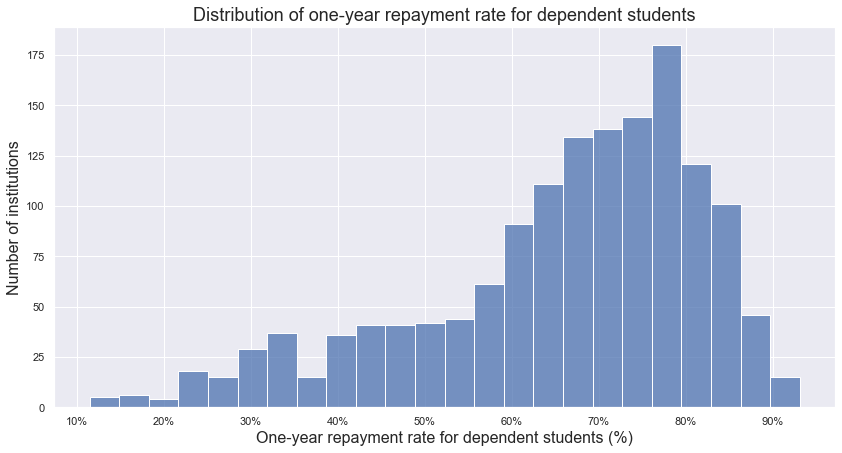

In [15]:
plt.figure(figsize=(14,7))
plot = sns.histplot(data=df, x='dep_rpy_1yr_rt')
plt.ylabel('Number of institutions', size=16)
plt.xlabel('One-year repayment rate for dependent students (%)', size=16)
plt.title('Distribution of one-year repayment rate for dependent students',size = 18)
plot.xaxis.set_major_formatter(ticker.PercentFormatter());

The repayment rate feature is skewed to the left. The histogram demonstrates that most institutions have a repayment rate for dependent students of 60% or more.

Based on the scatterplot of the relationship between repayment rate and median earnings, there is one observation with a repayment rate above 70% but very low of median earnings values. Drop this institution from the data set.

In [16]:
df[(df.dep_rpy_1yr_rt > 70) & (df.log_earnings < 10)][['instnm','unitid','dep_rpy_1yr_rt',
                                                         'md_earn_wne_p6','log_earnings']]

instnm  unitid  dep_rpy_1yr_rt  md_earn_wne_p6  log_earnings
164  Naropa University  127653       70.588235         16300.0       9.69892

In [17]:
df = df[df['unitid'] != 127653]

Search outliers using the method outlined earlier for non-normally distributed variables. Create a function for this purpose for use in other features.

In [18]:
def tukey_outlier_detection(feature, df=df):
    iqr= np.quantile(df[~df[feature].isnull()][feature],.75) - np.quantile(df[~df[feature].isnull()][feature],.25)
    quartile_3 = np.quantile(df[~df[feature].isnull()][feature],.75)
    quartile_1 = np.quantile(df[~df[feature].isnull()][feature],.25)
    
    return [(name,feat) for name,feat in zip(df[~df[feature].isnull()].instnm,
            df[~df[feature].isnull()][feature]) if (feat>quartile_3+1.5*iqr) 
            or (feat<quartile_1-1.5*iqr)]

In [19]:
tukey_outlier_detection('dep_rpy_1yr_rt')[:5]

[('Alabama State University', 24.73684211),
 ('Miles College', 16.42619312),
 ('Brookline College-Phoenix', 14.70588235),
 ('Brown Mackie College-Tucson', 22.535211269999998),
 ('Arkansas Baptist College', 20.63492063)]

Some institutions have an one-year repayment rate below 30% and are considered outliers based on Tuckey's rule. However, these institutions also have low median earnings post graduation, which is consistent with the hypothesis that institutions with higher repayment rates have higher earnings overall. Therefore, these low repayment rates appear to be consistent with assumptions about the data. These results are also consistent with the most recent data published on the College Scorecard [website](https://collegescorecard.ed.gov/school/?100724-Alabama-State-University). These data will be kept in the data set.

#### Average family income and percentage of students who have received a Pell Grant

On average, higher levels of family income are related to higher earnings. Although this correlation does not mean that students from more affluent households should be expected to be higher earners and students from less resourced households should not be, the data may be indicative of opportunity gaps for students from institutions that educate students from less resourced families and highlights an opportunity for these institutions to close that gap. Overall, a higher proportion of students who have received a [Pell Grant](https://www2.ed.gov/programs/fpg/index.html) is associated with lower median earnings and lower family incomes. Pell Grants are awards provided to students who demonstrate exceptional financial need and do not have to be repaid. They can be considered an instrument to increase access to higher education in the prospect of obtaining better earnings.

The log-transformation of average family income demonstrates a larger correlation to the log of median earnings compared to the linear average family income feature.

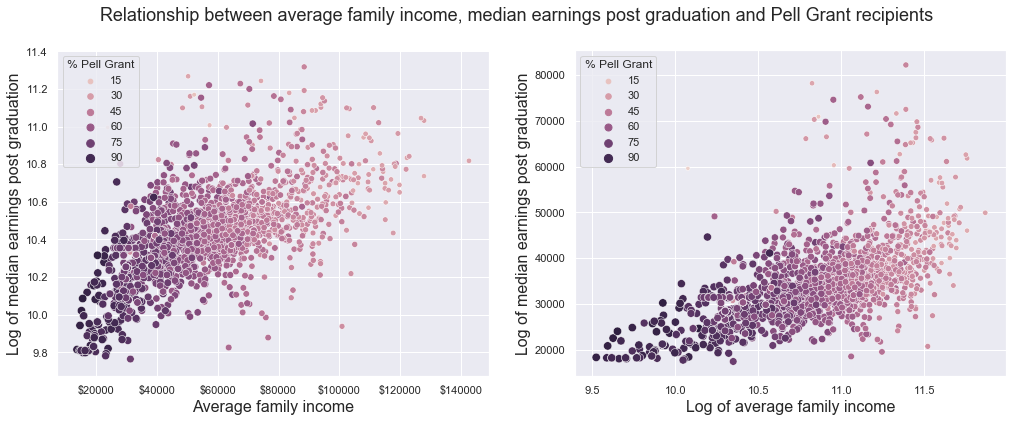

In [20]:
fig, axes = plt.subplots(1,2,figsize=(17,6))
ax0 = sns.scatterplot(data=df, x='faminc', y='log_earnings', ax=axes[0], hue='pell_ever', size='pell_ever')
ax1 = sns.scatterplot(data=df[~df.faminc.isnull()], x=np.log(df[~df.faminc.isnull()]['faminc']),
                  y='md_earn_wne_p6', ax=axes[1], hue='pell_ever', size='pell_ever')

formatter = ticker.FormatStrFormatter('$%1.0f')
ax0.xaxis.set_major_formatter(formatter)
ax0.set_ylabel('Log of median earnings post graduation', size=16),ax0.set_xlabel('Average family income',size=16)
ax1.set_ylabel('Log of median earnings post graduation',size=16),ax1.set_xlabel('Log of average family income',size=16);
ax0.legend(loc='upper left', title='% Pell Grant');
ax1.legend(loc='upper left', title='% Pell Grant');

fig.suptitle('Relationship between average family income, median earnings post graduation and Pell Grant recipients',
            size = 18);

plt.savefig('./assets/avgfaminc.png')

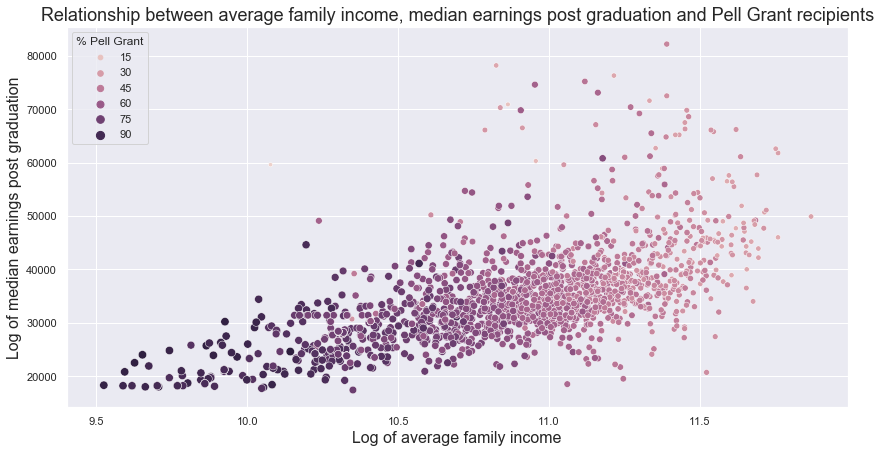

In [21]:
plt.figure(figsize=(14,7))
sns.scatterplot(data=df[~df.faminc.isnull()], x=np.log(df[~df.faminc.isnull()]['faminc']),
                  y='md_earn_wne_p6', hue='pell_ever', size='pell_ever')

plt.ylabel('Log of median earnings post graduation', size=16),
plt.xlabel('Log of average family income',size=16)
plt.legend(loc='upper left', title='% Pell Grant');

plt.title('Relationship between average family income, median earnings post graduation and Pell Grant recipients',
            size = 18);

plt.savefig('./assets/avgfaminc.png')

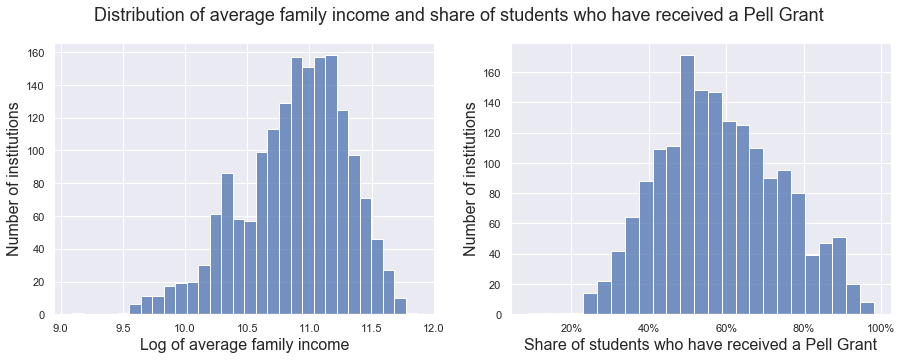

In [22]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
plot0 = sns.histplot(data=df[~df['faminc'].isnull()], x=np.log(df[~df['faminc'].isnull()]['faminc']), ax=axes[0])
plot1 = sns.histplot(data=df, x='pell_ever', ax=axes[1])
plot0.set_ylabel('Number of institutions',size=16)
plot1.set_ylabel('Number of institutions',size=16)
plot0.set_xlabel('Log of average family income',size=16)
plot1.set_xlabel('Share of students who have received a Pell Grant',size=16)
plot1.xaxis.set_major_formatter(ticker.PercentFormatter())

fig.suptitle('Distribution of average family income and share of students who have received a Pell Grant',size=18);

The tests below confirm that the log of average family income and share of students who have been awarded a Pell Grant are not normally distributed. The p-values are below a significance level of 0.05 and the null hypothesis of a normal distribution can be rejected.

Use Tukeys methods to detect these outliers.

In [23]:
normaltest(np.log(df[~df['faminc'].isnull()]['faminc']))

NormaltestResult(statistic=86.1146928871353, pvalue=1.9972481803846432e-19)

In [24]:
normaltest(df[~df['pell_ever'].isnull()]['pell_ever'])

NormaltestResult(statistic=44.32113731773553, pvalue=2.3756765761181837e-10)

In [25]:
df['log_faminc'] = np.log(df['faminc'])

In [26]:
tukey_outlier_detection('faminc')

[('Trinity College', 118650.42553),
 ('University of Notre Dame', 127886.4893),
 ('Loyola University Maryland', 122247.95408),
 ('Colgate University', 121970.22004),
 ('Elon University', 119840.62063),
 ('Wake Forest University', 122991.85203),
 ('Bucknell University', 119272.07627),
 ('Franklin and Marshall College', 127860.04085),
 ('Gettysburg College', 119802.41757),
 ("Saint Joseph's University", 118390.9798),
 ('Villanova University', 126884.5317),
 ('Washington and Lee University', 142665.11854)]

In [27]:
tukey_outlier_detection('log_faminc')[:5]

[('Concordia College Alabama', 9.680257852073687),
 ('Brookline College-Phoenix', 9.524915344974303),
 ('Everest University-Pompano Beach', 9.58854937149231),
 ('Everest University-North Orlando', 9.76880161556742),
 ('Altierus Career College-Tampa', 9.701977294901376)]

All outlier values in the average family income feature appear to be within a resonsable amount or less than $150,000. The logged-term of this feature has low outlier values, although these institutions appear to be at the lower end of the distribution and may reflect lower incomes and cost of living levels from institutions in the southern United States such as Concordia College Alabama.

In [28]:
tukey_outlier_detection('pell_ever')[:5]

[('Alliant International University-San Diego', 8.78378378)]

Only Alliant International University-San Diego is flagged as an outlier in the share of students who have received a Pell grant. This is a reasonable value for the share of Pell Grant students.

#### Percentage of students whose parents highest level of education is high school

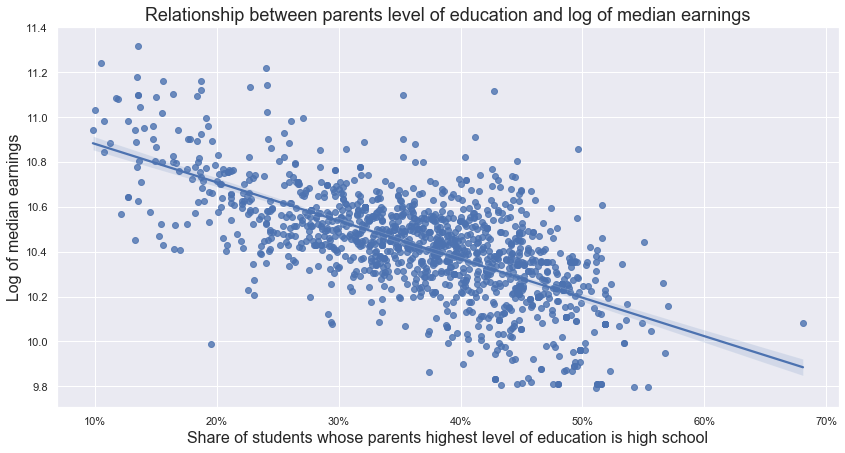

In [29]:
plt.figure(figsize=(14,7))
plot = sns.regplot(data=df, x='par_ed_pct_hs', y='log_earnings')
plt.ylabel('Log of median earnings', size=16)
plt.xlabel('Share of students whose parents'' highest level of education is high school', size=16)
plot.xaxis.set_major_formatter(ticker.PercentFormatter());
plt.title('Relationship between parents'' level of education and log of median earnings', size=18);

Overall, it appears that as the proportion of students whose parents' highest level of education is high-school is higher, the median earnings post graduation are lower. This signals that more needs to be done in the higher education system to close earnings gaps for students from families with lower levels of education.

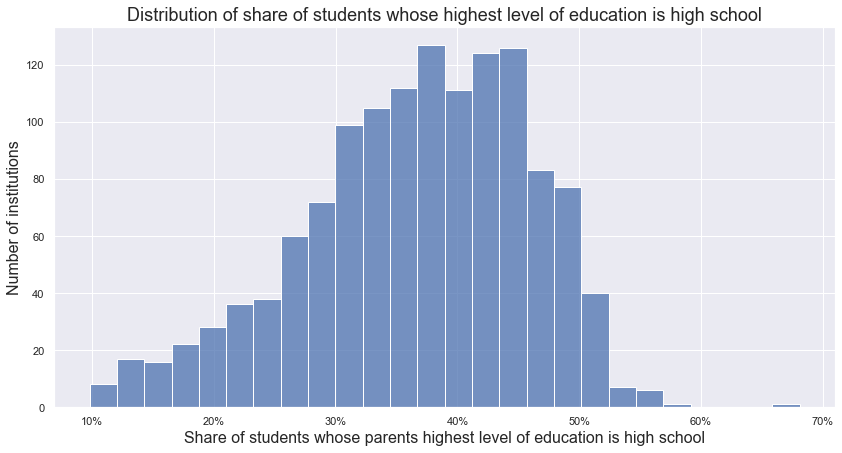

In [30]:
plt.figure(figsize=(14,7))
plot = sns.histplot(data=df, x='par_ed_pct_hs')
plt.ylabel('Number of institutions', size=16)
plt.xlabel('Share of students whose parents'' highest level of education is high school', size=16)
plt.title('Distribution of share of students whose highest level of education is high school',size = 18)
plot.xaxis.set_major_formatter(ticker.PercentFormatter());

The share of students whose parents' highest level of education is high school is not normally distributed. The outliers in this feature are inspected below.

In [31]:
tukey_outlier_detection('par_ed_pct_hs')

[('Georgetown University', 11.66992188),
 ('Northwestern University', 10.73170732),
 ('University of Notre Dame', 10.01283697),
 ('Tufts University', 10.70911722),
 ('Washington University in St Louis', 9.80769231),
 ('Northern New Mexico College', 68.09917355),
 ('Cornell University', 11.85607041),
 ('Duke University', 10.49748973),
 ('Vanderbilt University', 11.17647059)]

In [32]:
df[(df['instnm']=='Georgetown University') | (df['instnm']=='Northern New Mexico College')][['instnm','unitid','par_ed_pct_hs','faminc','md_earn_wne_p6']]

instnm  unitid  par_ed_pct_hs        faminc  \
202        Georgetown University  131496      11.669922  92172.723944   
830  Northern New Mexico College  188058      68.099174  19692.252570   

     md_earn_wne_p6  
202         65200.0  
830         23900.0

The outliers identified above are expected for institutions such as Georgetown University, where the average family income is close $100,000.

However, Northern New Mexico College is significantly apart from all other institutions and is considered an outlier. This institution will be removed from the data set.

In [33]:
df = df[df['unitid'] != 188058]

#### Open admissions policy

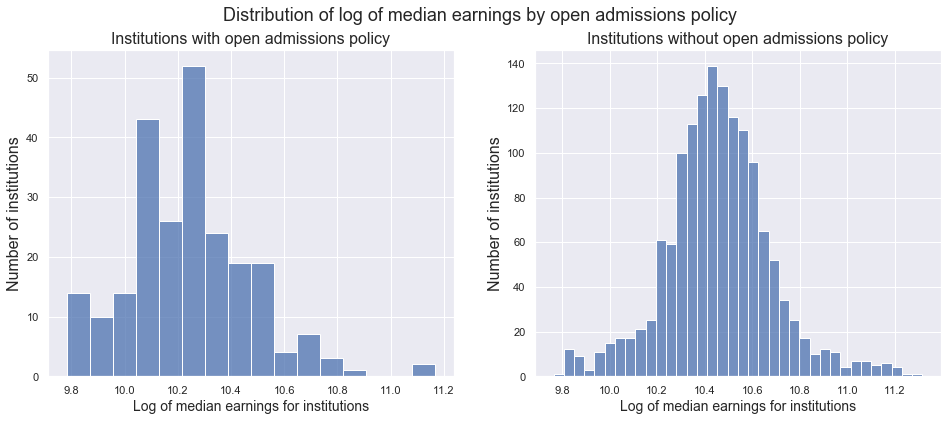

In [34]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
plot0 = sns.histplot(data = df[df.openadmp == 1], x='log_earnings', ax=axes[0])
plot1 = sns.histplot(data = df[df.openadmp == 2], x='log_earnings', ax=axes[1])

plot0.set_xlabel('Log of median earnings for institutions', size=14)
plot1.set_xlabel('Log of median earnings for institutions', size=14)
plot0.set_ylabel('Number of institutions', size=16)
plot1.set_ylabel('Number of institutions', size=16)
plot0.set_title('Institutions with open admissions policy', size=16)
plot1.set_title('Institutions without open admissions policy', size=16)

fig.suptitle('Distribution of log of median earnings by open admissions policy',size=18);

In [35]:
df.groupby('openadmp')['log_earnings'].agg(['mean','median','var'])

mean     median       var
openadmp                                
1.0       10.238832  10.238171  0.053512
2.0       10.457442  10.451609  0.050700

In [36]:
df.groupby('openadmp')['md_earn_wne_p6'].agg(['mean','median','var'])

mean   median           var
openadmp                                     
1.0       28765.966387  27950.0  5.447930e+07
2.0       35713.037448  34600.0  7.183554e+07

The histogram and tabulation of the log of median earnings by whether an institution has an open admissions policy does not demonstrate large differences by the admissions policy type. An open admissions policy is one that does not require admissions tests such as SAT scores and is an option to increase access to higher education for underserved communities. There is significant variability in median earnings by whether an institution has an open admissions policy or not. Although the median, mean, and variance of the log of the median earnings by the open admissions policy indicator do not differ signficantly, this feature will be included in the model based on the variability in the linear median earnings feature.

In [37]:
df.loc[df['openadmp']==2,'openadmp'] = 0

/Users/efesios659/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Institution type

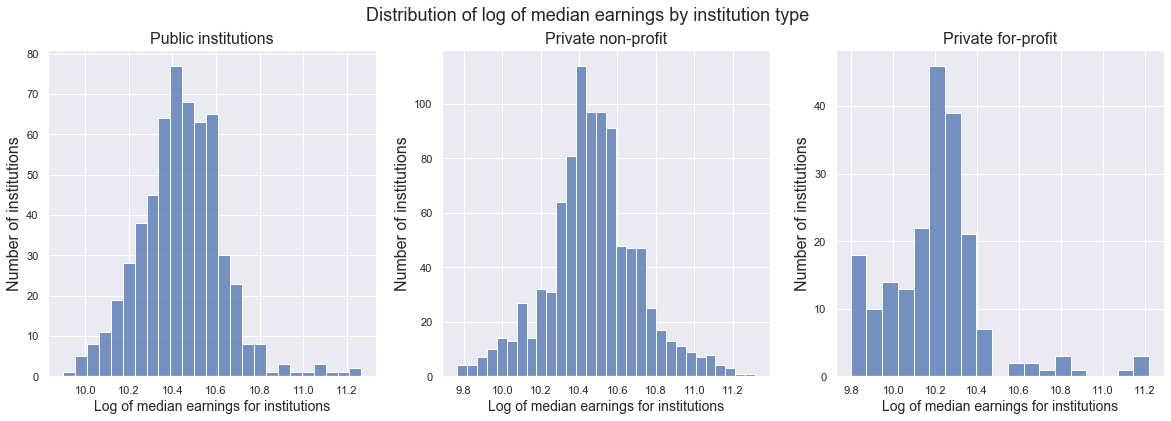

In [38]:
fig, axes = plt.subplots(1,3,figsize=(20,6))
plot0 = sns.histplot(data = df[df.control == 1], x='log_earnings', ax=axes[0])
plot1 = sns.histplot(data = df[df.control == 2], x='log_earnings', ax=axes[1])
plot2 = sns.histplot(data = df[df.control == 3], x='log_earnings', ax=axes[2])

plot0.set_xlabel('Log of median earnings for institutions', size=14)
plot1.set_xlabel('Log of median earnings for institutions', size=14)
plot2.set_xlabel('Log of median earnings for institutions', size=14)

plot0.set_ylabel('Number of institutions', size=16)
plot1.set_ylabel('Number of institutions', size=16)
plot2.set_ylabel('Number of institutions', size=16)

plot0.set_title('Public institutions', size=16)
plot1.set_title('Private non-profit', size=16)
plot2.set_title('Private for-profit', size=16)

fig.suptitle('Distribution of log of median earnings by institution type',size=18);

In [39]:
df.groupby('control')['log_earnings'].agg(['mean','median','var'])

mean     median       var
control                                
1.0      10.441185  10.438517  0.037262
2.0      10.472370  10.465956  0.057524
3.0      10.208334  10.229188  0.059942

In [40]:
df.groupby('control')['md_earn_wne_p6'].agg(['mean','median','var'])

mean   median           var
control                                     
1.0      34906.620209  34150.0  5.249455e+07
2.0      36367.800213  35100.0  8.233333e+07
3.0      28044.334975  27700.0  7.040050e+07

There is not significant variability in the log of median earnings by institution type except among private for-profit institutions, which represent the minority of institutions in the data set. However, there is signficant variation in the median earnings by the institution type. Private-non-profit institutions have the highest median earnings in the data set, while private-for-profit institutions have the lowest. This feature will be included in the model based on the variability of median earnings by institution type.

#### Predominant degree awarded

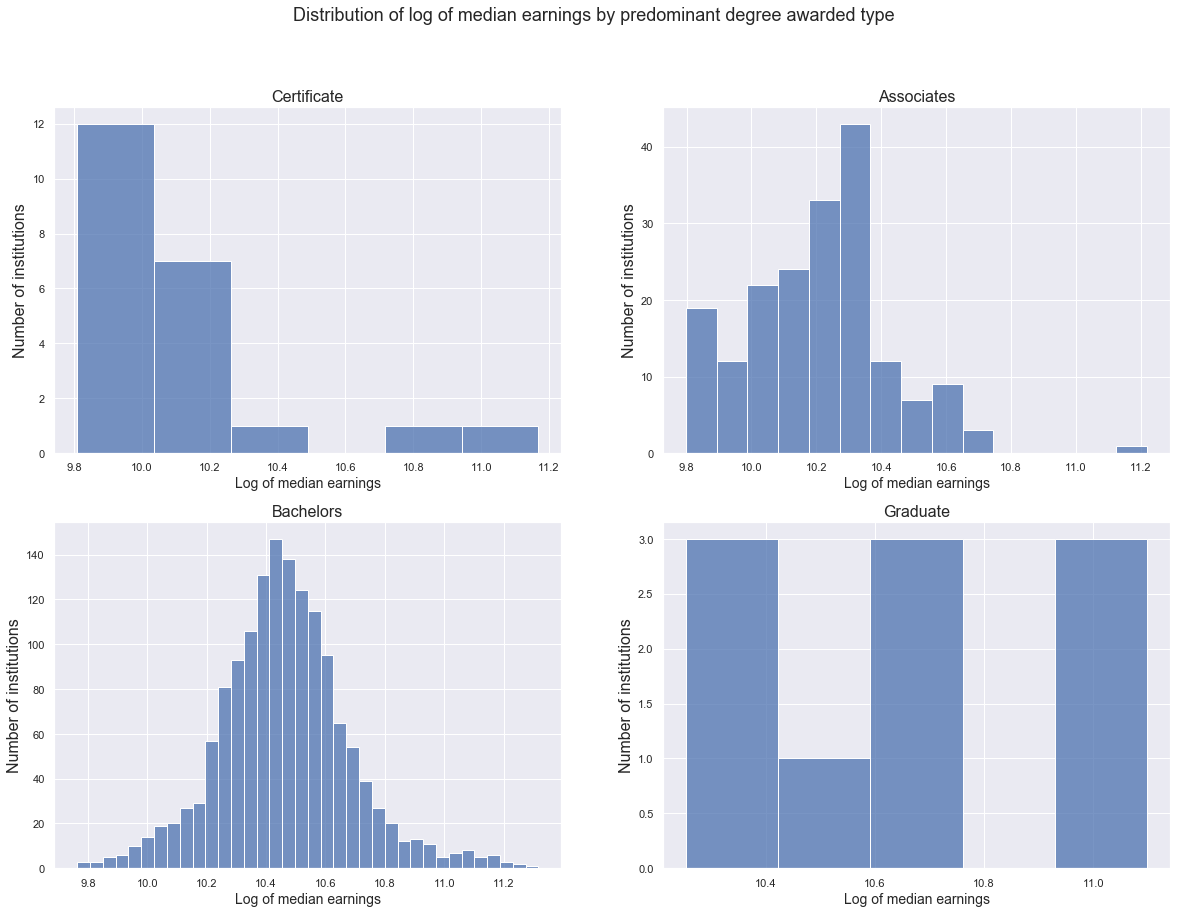

In [41]:
fig, axes = plt.subplots(2,2,figsize=(20,14))
plot0 = sns.histplot(data = df[df.preddeg == 1], x='log_earnings', ax=axes[0,0])
plot1 = sns.histplot(data = df[df.preddeg == 2], x='log_earnings', ax=axes[0,1])
plot2 = sns.histplot(data = df[df.preddeg == 3], x='log_earnings', ax=axes[1,0])
plot3 = sns.histplot(data = df[df.preddeg == 4], x='log_earnings', ax=axes[1,1])

plot0.set_xlabel('Log of median earnings', size=14)
plot1.set_xlabel('Log of median earnings', size=14)
plot2.set_xlabel('Log of median earnings', size=14)
plot3.set_xlabel('Log of median earnings', size=14)

plot0.set_ylabel('Number of institutions', size=16)
plot1.set_ylabel('Number of institutions', size=16)
plot2.set_ylabel('Number of institutions', size=16)
plot3.set_ylabel('Number of institutions', size=16)

plot0.set_title('Certificate', size=16)
plot1.set_title('Associate''s', size=16)
plot2.set_title('Bachelor''s', size=16)
plot3.set_title('Graduate', size=16)

fig.suptitle('Distribution of log of median earnings by predominant degree awarded type',size=18);

In [42]:
df.groupby('preddeg')['log_earnings'].agg(['mean','median','var'])

mean     median       var
preddeg                                
1.0      10.103352   9.994242  0.108019
2.0      10.210372  10.221941  0.049902
3.0      10.461180  10.451609  0.049185
4.0      10.660826  10.610229  0.086386

In [43]:
df.groupby('preddeg')['md_earn_wne_p6'].agg(['mean','median','var'])

mean   median           var
preddeg                                     
1.0      26031.818182  21900.0  1.432375e+08
2.0      27894.054054  27500.0  4.629980e+07
3.0      35825.916056  34600.0  7.142225e+07
4.0      44370.000000  40550.0  1.785801e+08

Institutions whose predominant degree awarded is a Bachelor's or graduate degree have hgiher average and median log earnings compared to their counterparts. Among institutions whose predominant degree awarded is a Bachelor's or Graduate degree, the linear median earnings feature is highest and lowest among institutions whose predominant degree type awarded is a Certificate. This feature will be included in the model based on the variation of median earnings by institution type.

### Research intensive institutions

In [44]:
df.groupby(df['ccbasic'].map({14:'Associate''s--Private For-profit 4-year Primarily Associate''s',
                   15:'Research Universities (very high research activity)',
                   16:'Research Universities (high research activity)',
                   17:'Doctoral/Research Universities',
                   18:'Master''s Colleges and Universities (larger programs)',
                   19:'Master''s Colleges and Universities (medium programs)',
                   20:'Master''s Colleges and Universities (smaller programs)',
                   21:'Baccalaureate Colleges--Arts & Sciences',
                   22:'Baccalaureate Colleges--Diverse Fields',
                   23:'Baccalaureate/Associate''s Colleges'}))['md_earn_wne_p6'].median()

ccbasic
Associates--Private For-profit 4-year Primarily Associates    27700.0
Baccalaureate Colleges--Arts & Sciences                       34100.0
Baccalaureate Colleges--Diverse Fields                        32150.0
Baccalaureate/Associates Colleges                             26600.0
Doctoral/Research Universities                                36500.0
Masters Colleges and Universities (larger programs)           35700.0
Masters Colleges and Universities (medium programs)           34900.0
Masters Colleges and Universities (smaller programs)          33400.0
Research Universities (high research activity)                37700.0
Research Universities (very high research activity)           42700.0
Name: md_earn_wne_p6, dtype: float64

Institutions with Carnegie Classifications of Doctoral/Research Universiities with high research activity or masters colleges and universities have larger median earnings compared to all other Carnegie Classifications. Create a binary feature for whether an institution belong to one of these categories to use in the modeling process. Institutions with higher research activity tend to receive more resources from State education agencies and research grants, which may provide greater opportunity for professional development for students and greater opportunities to pursue higher earning jobs.

In [45]:
df['high_research_and_grad'] = df['ccbasic'].apply(lambda x: 1 if x in range(15,21) else 0)

/Users/efesios659/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



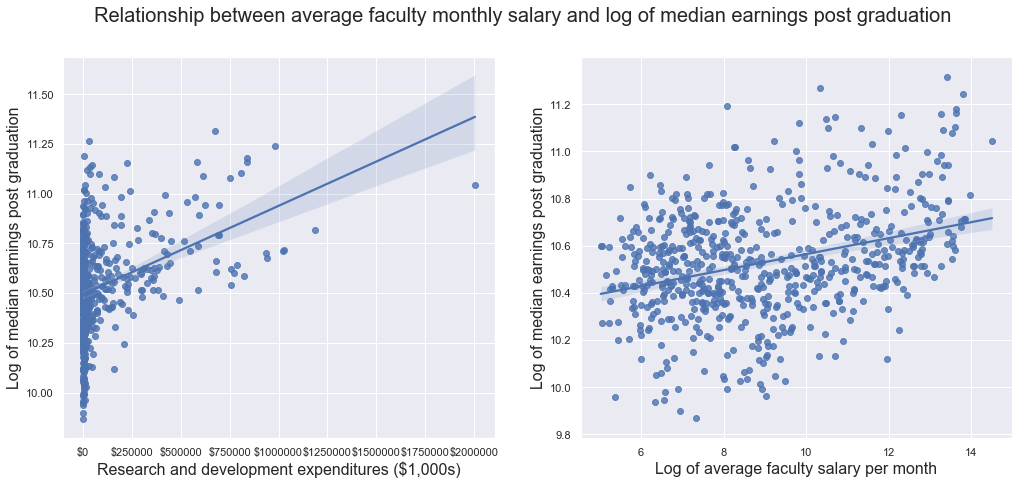

In [46]:
fig, axes = plt.subplots(1,2,figsize=(17,7))

ax0 = sns.regplot(data=df, x='rd_exp', y='log_earnings', ax=axes[0])
ax0.xaxis.set_major_formatter(formatter)
ax0.set_ylabel('Log of median earnings post graduation', size = 16)
ax0.set_xlabel('Research and development expenditures ($1,000s)', size = 16)

ax1 = sns.regplot(data=df[~df.rd_exp.isnull()], x=np.log(df[~df.rd_exp.isnull()]['rd_exp']), 
                  y='log_earnings', ax=axes[1])
ax1.set_ylabel('Log of median earnings post graduation', size = 16)
ax1.set_xlabel('Log of average faculty salary per month', size = 16)

fig.suptitle('Relationship between average faculty monthly salary and log of median earnings post graduation', 
             size =20);

There is not a clear relationship between the research and development expenditures from the National Science Foundation and median earnings post graduation. Therefore, this feature will not be included in the features used to model median earnings.

#### Average faculty salary

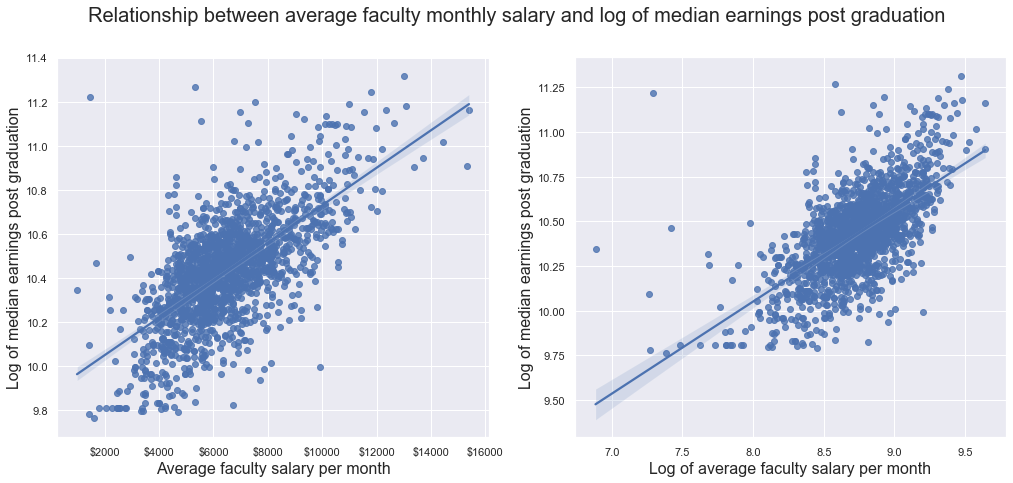

In [47]:
fig, axes = plt.subplots(1,2,figsize=(17,7))

ax0 = sns.regplot(data=df, x='avgfacsal', y='log_earnings', ax=axes[0])
ax0.xaxis.set_major_formatter(formatter)
ax0.set_ylabel('Log of median earnings post graduation', size = 16)
ax0.set_xlabel('Average faculty salary per month', size = 16)

ax1 = sns.regplot(data=df[~df.avgfacsal.isnull()], x=np.log(df[~df.avgfacsal.isnull()]['avgfacsal']), 
                  y='log_earnings', ax=axes[1])
ax1.set_ylabel('Log of median earnings post graduation', size = 16)
ax1.set_xlabel('Log of average faculty salary per month', size = 16)

fig.suptitle('Relationship between average faculty monthly salary and log of median earnings post graduation', 
             size =20);

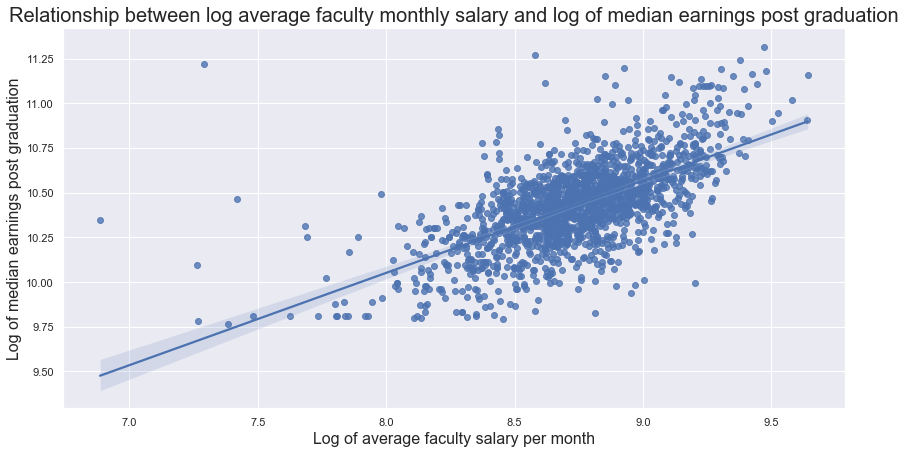

In [48]:
plt.figure(figsize=(14,7))

sns.regplot(data=df[~df.avgfacsal.isnull()], x=np.log(df[~df.avgfacsal.isnull()]['avgfacsal']), 
                  y='log_earnings')
plt.ylabel('Log of median earnings post graduation', size = 16)
plt.xlabel('Log of average faculty salary per month', size = 16)

plt.title('Relationship between log average faculty monthly salary and log of median earnings post graduation', 
             size =20);

plt.savefig('./assets/avgfacsal.png')

Average faculty salary per month has a positive relationship with the log of median earnings. On average, as the average salary increases, the log of the median earnings post graduation tends to increase. Some institutions have a very high average salary per month at just below $16,000. 

Average faculty salary, similarly to median earnings, is a monetary measure that reflects high variability with values ranging from \\$2,000 to \\$16,000. A log-transformation of this feature appears to have a more linear relationship with the log of median earnings. However, it appears the are outliers in this feature that should be removed from the data set. Institutions such as `West Coast University-Los Angeles`,`Louisiana State University Health Sciences Center`, and `Chamberlain University-Ohio` have high median earnings values but comparably lower average monthly faculty salaries. Therefore, these observations will be dropped. 

In [49]:
df[(df['log_earnings']>11) & ((df['avgfacsal'] < 6000) | (df['avgfacsal'] > 14000)) | (df['avgfacsal'] < 2000)]\
    [['instnm','unitid','md_earn_wne_p6','avgfacsal']].sort_values(by='avgfacsal')

instnm  unitid  \
551                          Sojourner-Douglass College  163921   
1397                            Stevens-Henager College  230621   
1458                   Virginia University of Lynchburg  234137   
1665                  West Coast University-Los Angeles  443331   
430                  Maharishi International University  153861   
569                                   Cambridge College  165167   
1575                        Everest University-Lakeland  367909   
1633  Louisiana State University Health Sciences Cen...  435000   
1722                        Chamberlain University-Ohio  454236   
811                                Princeton University  186131   
582                                  Harvard University  166027   

      md_earn_wne_p6  avgfacsal  
551          31100.0      978.0  
1397         24200.0     1426.0  
1458         17700.0     1434.0  
1665         74600.0     1464.0  
430          17400.0     1612.0  
569          35100.0     1667.0  
1575         18200.0     1777.0  
1633         78200.0     5315.0  
1722         67100.0     5537.0  
811          60800.0    14459.0  
582          70300.0    15403.0

In [50]:
df = df[~df['unitid'].isin([163921,230621,234137,153861,165167,367909,443331,435000,443331])]

Some of these institutions average faculty salaries may reflect human error in the data. For instance, for West Coast University-Los Angeles, the average faculty monthly salaries in the 2009-2010 academic year was more than twice the amount in 2008-2009, which may reflect a data reporting error in 2008-2009.

In [51]:
df_ny = pd.read_csv('./data/MERGED2009_10_PP.csv', usecols=['INSTNM','UNITID','AVGFACSAL'])
df_ny[(df_ny['UNITID']==443331) | (df_ny['UNITID']==435000) | (df_ny['UNITID']==454236)]

UNITID                                             INSTNM  AVGFACSAL
5660  435000  Louisiana State University Health Sciences Cen...     5370.0
6016  443331                  West Coast University-Los Angeles     7598.0
6726  454236                        Chamberlain University-Ohio     5984.0

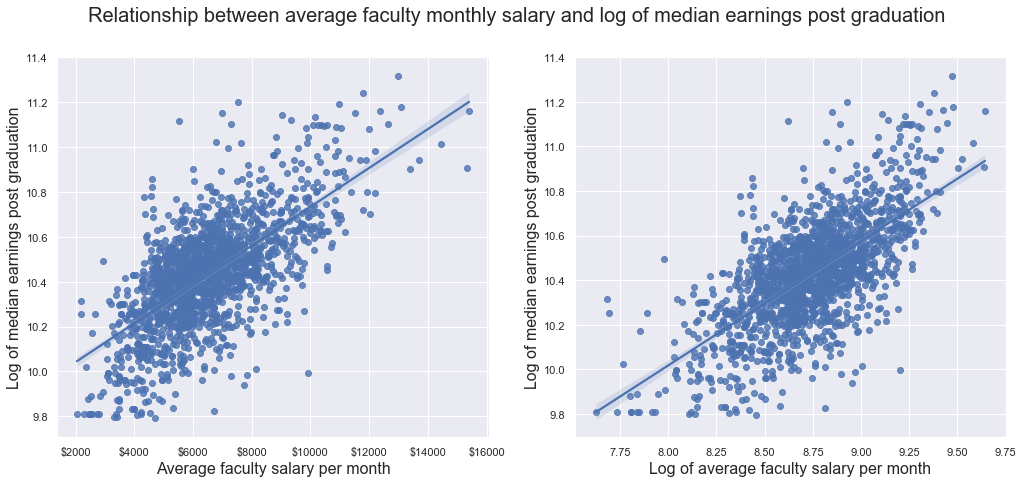

In [52]:
fig, axes = plt.subplots(1,2,figsize=(17,7))

ax0 = sns.regplot(data=df, x='avgfacsal', y='log_earnings', ax=axes[0])
formatter = ticker.FormatStrFormatter('$%1.0f')
ax0.xaxis.set_major_formatter(formatter)
ax0.set_ylabel('Log of median earnings post graduation', size = 16)
ax0.set_xlabel('Average faculty salary per month', size = 16)

ax1 = sns.regplot(data=df[~df.avgfacsal.isnull()], x=np.log(df[~df.avgfacsal.isnull()]['avgfacsal']), 
                  y='log_earnings', ax=axes[1])
ax1.set_ylabel('Log of median earnings post graduation', size = 16)
ax1.set_xlabel('Log of average faculty salary per month', size = 16)

fig.suptitle('Relationship between average faculty monthly salary and log of median earnings post graduation', 
             size =20);

plt.savefig('./assets/avgfacsal.png')

Removing these outliers improves the relationship between the lgo of average faculty salary and log of median earnings.

In [53]:
df['log_avgfacsal'] = np.log(df['avgfacsal'])

### Median math SAT score

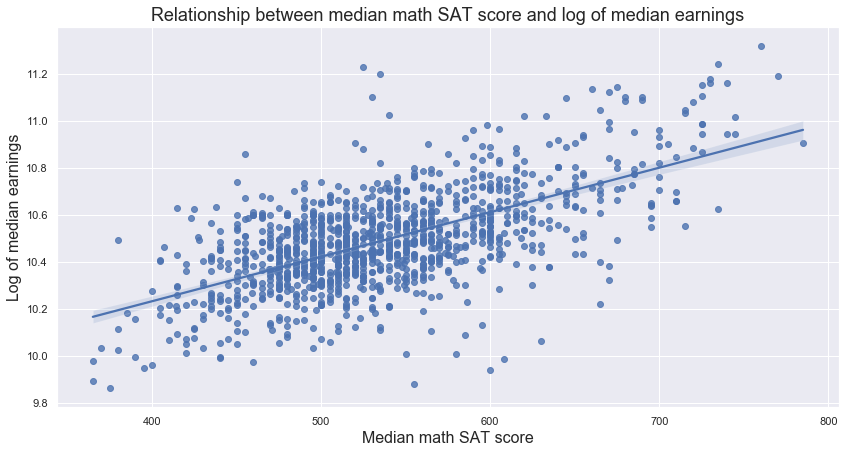

In [54]:
plt.figure(figsize=(14,7))
sns.set_theme()
plot = sns.regplot(data=df, x='satmtmid', y='log_earnings')
plt.ylabel('Log of median earnings', size=16)
plt.xlabel('Median math SAT score', size=16)
plt.title('Relationship between median math SAT score and log of median earnings', size=18);

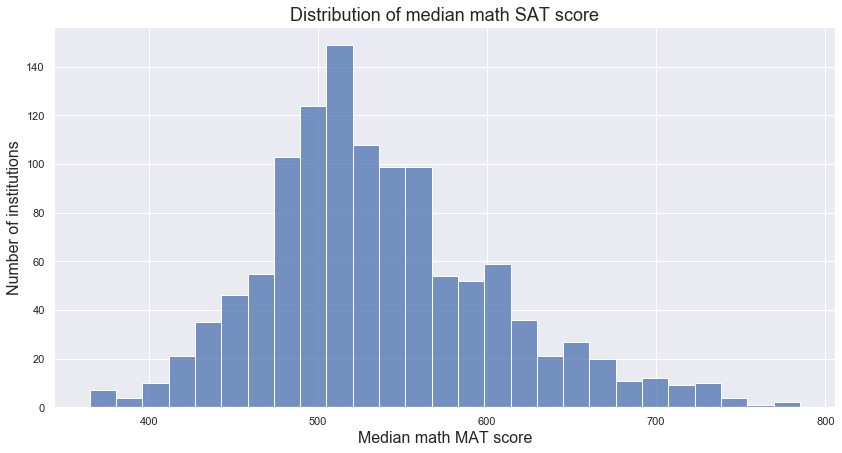

In [55]:
plt.figure(figsize=(14,7))
sns.histplot(data=df, x='satmtmid')
plt.ylabel('Number of institutions', size=16)
plt.xlabel('Median math MAT score', size=16)
plt.title('Distribution of median math SAT score', size=18);

There is a positive relationship between the median math SAT score and the log of median earnings. More selective institutions, on average, appear to have students with higher median earnings. This feature is roughly normally distributed. All values fall within the expected ranges of 200 and 800. Therefore, it does not appear that there is data from this feature that should be removed.

In [56]:
df.satmtmid.describe().T

count    1178.000000
mean      536.080645
std        68.886096
min       365.000000
25%       490.000000
50%       528.000000
75%       573.000000
max       785.000000
Name: satmtmid, dtype: float64

### Two-year cohort default rate

In [57]:
df['log_cdr2'] = [np.log(cdr2) if cdr2 > 0 and cdr2 != np.nan else cdr2 for cdr2 in df.cdr2]

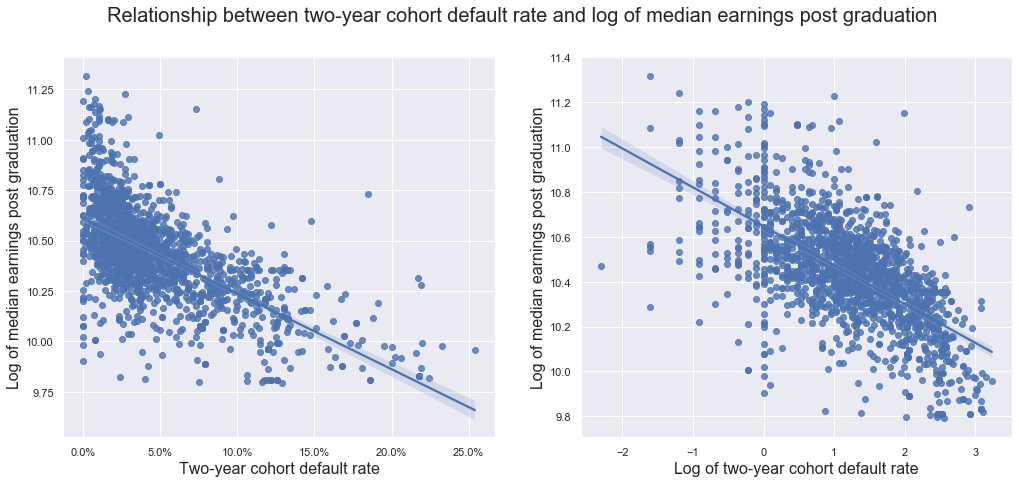

In [58]:
fig, axes = plt.subplots(1,2,figsize=(17,7))

ax0 = sns.regplot(data=df, x='cdr2', y='log_earnings', ax=axes[0])
ax0.xaxis.set_major_formatter(ticker.PercentFormatter())
ax0.set_ylabel('Log of median earnings post graduation', size = 16)
ax0.set_xlabel('Two-year cohort default rate', size = 16)

ax1 = sns.regplot(data=df, x='log_cdr2', 
                  y='log_earnings', ax=axes[1])
ax1.set_ylabel('Log of median earnings post graduation', size = 16)
ax1.set_xlabel('Log of two-year cohort default rate', size = 16)

fig.suptitle('Relationship between two-year cohort default rate and log of median earnings post graduation', size =20);

plt.savefig('./assets/cdr2.png')

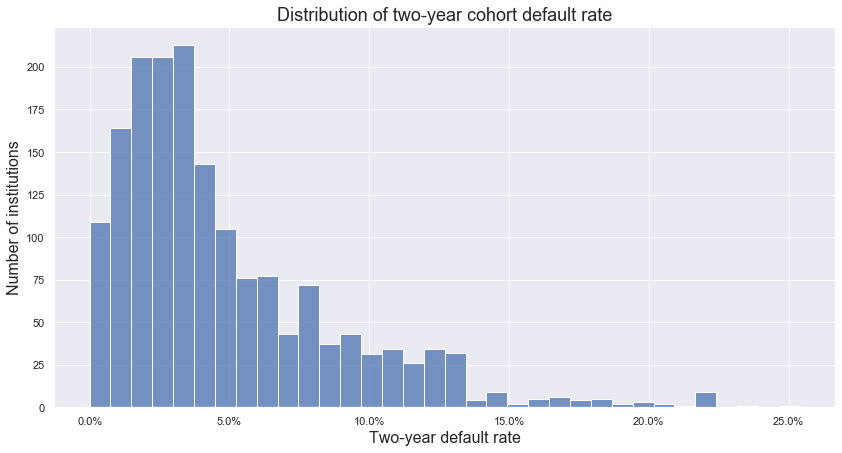

In [59]:
plt.figure(figsize=(14,7))
plot = sns.histplot(data=df, x = df.cdr2)
plot.xaxis.set_major_formatter(ticker.PercentFormatter())
plt.ylabel('Number of institutions',size=16)
plt.xlabel('Two-year default rate',size=16)
plt.title('Distribution of two-year cohort default rate',size=18);

In [60]:
tukey_outlier_detection('cdr2')[:5]

[('Alabama State University', 16.900000000000002),
 ('Miles College', 13.900000000000002),
 ('Talladega College', 20.599999999999998),
 ('Western International University', 18.5),
 ('Arkansas Baptist College', 18.099999999999998)]

In [61]:
df[df['cdr2'] > 23][['instnm','unitid','md_earn_wne_p6','cdr2']]

instnm  unitid  md_earn_wne_p6  cdr2
1344  Jarvis Christian College  225885         21100.0  25.4
1381             Texas College  228884         21500.0  23.3

Institutions whose graduates are able to make progress in repaying educational loans within two years may be more likely to be earning higher wages and less likely to be in default or delayed in educational loan payments. There appears to be a negative relationship, as expected, between a higher two-year cohort default rate and the log of median earnings. This feature is skewed to the right, signaling that most institutions have a two-year cohort default rate between 0%-5%, but some institutions have a very high value, sometimes above 10%. The institution with the highest two-year cohort default rate will be removed from the data set because it is significantly different from all other institutions in the data set.

In [62]:
df = df[(df['unitid'] != 225885) & (df['unitid'] != 228884)]

### Growth in median earnings over time

In the following cells, previous editions from The College Scorecard data for which earnings data are available dating back to academic years 2005-2006, are ingested to calculate an overall earnings growth from 2005-2006 to academic year 2013-2014, excluding 2014-2015 to avoid including the explained variable in the computation of an explanatory variable. It is expected that higher growth in earnings should signal improved outcomes over time for students and a predictor of better future outcomes.

Generate a data frame that will contain year-specific median earnings data joined by the common `UNITID`.

In [63]:
years = [file.split('.')[0].split('MERGED')[1].replace('_PP','') \
     for file in sorted([file for file in os.listdir('./data/') if 'MERGED' in file])]

In [64]:
files = sorted([file for file in os.listdir('./data/') if 'MERGED' in file])

In [65]:
data_frames = {}

In [66]:
for file,year in zip(files,years):
    data_frames[year] = pd.read_csv('./data/'+file, usecols=['UNITID','MD_EARN_WNE_P6'])
    data_frames[year].columns = data_frames[year].columns.str.lower()
    data_frames[year].rename(columns={'md_earn_wne_p6':'md_earn_wne_p6'+'_'+year},inplace=True)

In [67]:
df_years = data_frames['2003_04'].merge(data_frames['2013_14'], how = 'outer', on = 'unitid')

In [68]:
df_years = df[['instnm','unitid']].merge(df_years, how='left', on='unitid')

Search for missing values.

In [69]:
df_years = df_years[['unitid','md_earn_wne_p6_2003_04','md_earn_wne_p6_2013_14']]

In [70]:
df_years.isnull().sum()

unitid                     0
md_earn_wne_p6_2003_04    64
md_earn_wne_p6_2013_14     1
dtype: int64

Change the data type of median earnings and one-year repayment rate features.

In [71]:
for col in [col for col in df_years.columns if df_years[col].dtypes == 'O']:
    df_years.loc[df_years[col]=='PrivacySuppressed', col] = np.nan
    
    try:
        df_years[col] = df_years[col].astype(float)
    except:
        pass

Drop institutions with null values after filtering the data set. These represent a small portion of the overall data set.

In [72]:
df_years.isnull().sum()

unitid                     0
md_earn_wne_p6_2003_04    85
md_earn_wne_p6_2013_14     2
dtype: int64

In [73]:
df_years.dropna(inplace=True)

Calculate the median earnings growth as the percentage change in median earnings between academic years 2005-2006 and 2013-2014.

In [74]:
df_years['med_earnings_growth'] = 100*(df_years['md_earn_wne_p6_2013_14'] - df_years['md_earn_wne_p6_2003_04']) \
                                / (df_years['md_earn_wne_p6_2003_04'])

In [75]:
df = df.merge(df_years[['unitid','med_earnings_growth']], how = 'left', on = 'unitid')

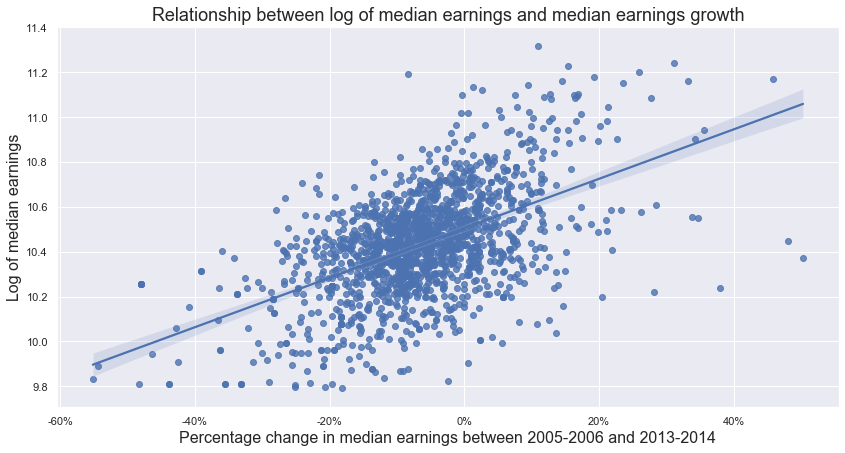

In [76]:
plt.figure(figsize=(14,7))
plot = sns.regplot(data=df, x='med_earnings_growth', y='log_earnings')
plt.ylabel('Log of median earnings',size=16)
plt.xlabel('Percentage change in median earnings between 2005-2006 and 2013-2014',size=16)
plot.xaxis.set_major_formatter(ticker.PercentFormatter())
plt.title('Relationship between log of median earnings and median earnings growth',size=18);

Overall, it appears that as the median earnings growth increases, the log of median earnings also increases. However, it also appears that there are some institutions with very large changes in median earnings in both directions. Based on the plot below, the distribution of the growth in median earnings appears to be roughly normally distributed. However, it appears that the mean of the distribution is a growth in median earnings below zero. There is also wide spread in this feature. The outliers are inspected below.

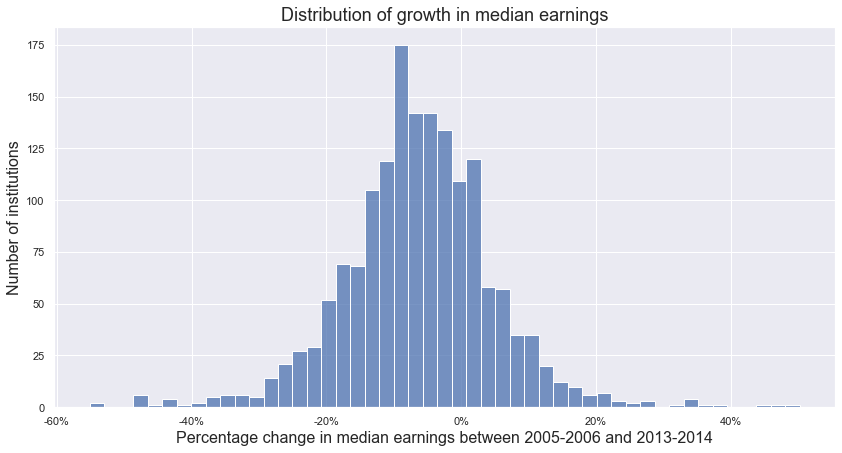

In [77]:
plt.figure(figsize=(14,7))
plot = sns.histplot(data=df,x='med_earnings_growth')
plot.xaxis.set_major_formatter(ticker.PercentFormatter())
plt.ylabel('Number of institutions',size=16)
plt.xlabel('Percentage change in median earnings between 2005-2006 and 2013-2014',size=16)
plt.title('Distribution of growth in median earnings',size=18);

Many of the institutions that have median earnings growth below 40% appear to be campuses or branches of `University of Phoenix`. These institutions' median earnings appear to be on the lower end of the median earnings distribution. Remove these institutions as outliers. 

In [78]:
df[(df.med_earnings_growth < np.mean(df['med_earnings_growth']) - 3 * np.std(df['med_earnings_growth'])) | \
   (df.med_earnings_growth > np.mean(df['med_earnings_growth']) + 3 * np.std(df['med_earnings_growth']))]\
    [['instnm','unitid','med_earnings_growth','log_earnings','md_earn_wne_p6']].\
    sort_values(by='med_earnings_growth').head(10)

instnm  unitid  med_earnings_growth  \
158              CollegeAmerica-Denver  126872           -55.137845   
1538      Brightwood College-Nashville  246202           -54.439252   
227   Everest University-Pompano Beach  134149           -48.348348   
1638       University of Phoenix-Idaho  440466           -48.040886   
1611      University of Phoenix-Oregon  432241           -48.040886   
1600      University of Phoenix-Hawaii  420042           -48.040886   
1582  University of Phoenix-New Mexico  405997           -48.040886   
1571        University of Phoenix-Utah  380465           -48.040886   
831      Globe Institute of Technology  188465           -46.400000   
249           Everest University-Largo  137810           -43.816254   

      log_earnings  md_earn_wne_p6  
158       9.830917         18600.0  
1538      9.888374         19700.0  
227       9.809177         18200.0  
1638     10.254144         28400.0  
1611     10.254144         28400.0  
1600     10.254144         28400.0  
1582     10.254144         28400.0  
1571     10.254144         28400.0  
831       9.942708         20800.0  
249       9.809177         18200.0

In [79]:
df = df[~(df['med_earnings_growth'] < - 40)]

### Completion rate for first-time, full-time students within 150% of expected completion time

In [80]:
df['log_c150_4'] = np.log(df['c150_4'])

/Users/efesios659/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning:

divide by zero encountered in log



/Users/efesios659/opt/anaconda3/lib/python3.7/site-packages/numpy/core/function_base.py:151: RuntimeWarning:

invalid value encountered in multiply

/Users/efesios659/opt/anaconda3/lib/python3.7/site-packages/numpy/core/function_base.py:161: RuntimeWarning:

invalid value encountered in add

/Users/efesios659/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1396: RuntimeWarning:

All-NaN slice encountered



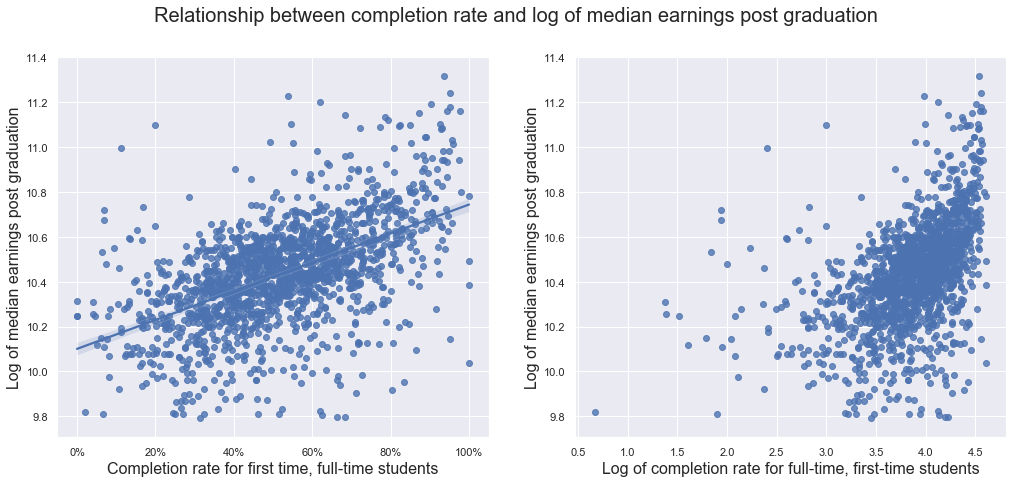

In [81]:
fig, axes = plt.subplots(1,2,figsize=(17,7))

ax0 = sns.regplot(data=df, x='c150_4', y='log_earnings', ax=axes[0])
ax0.xaxis.set_major_formatter(ticker.PercentFormatter())
ax0.set_ylabel('Log of median earnings post graduation', size = 16)
ax0.set_xlabel('Completion rate for first time, full-time students', size = 16)

ax1 = sns.regplot(data=df, x='log_c150_4', 
                  y='log_earnings', ax=axes[1])
ax1.set_ylabel('Log of median earnings post graduation', size = 16)
ax1.set_xlabel('Log of completion rate for full-time, first-time students', size = 16)

fig.suptitle('Relationship between completion rate and log of median earnings post graduation',
             size =20);

In [82]:
df[['log_c150_4','log_earnings','c150_4']].corr()

log_c150_4  log_earnings    c150_4
log_c150_4      1.000000      0.481731  0.939465
log_earnings    0.481731      1.000000  0.538335
c150_4          0.939465      0.538335  1.000000

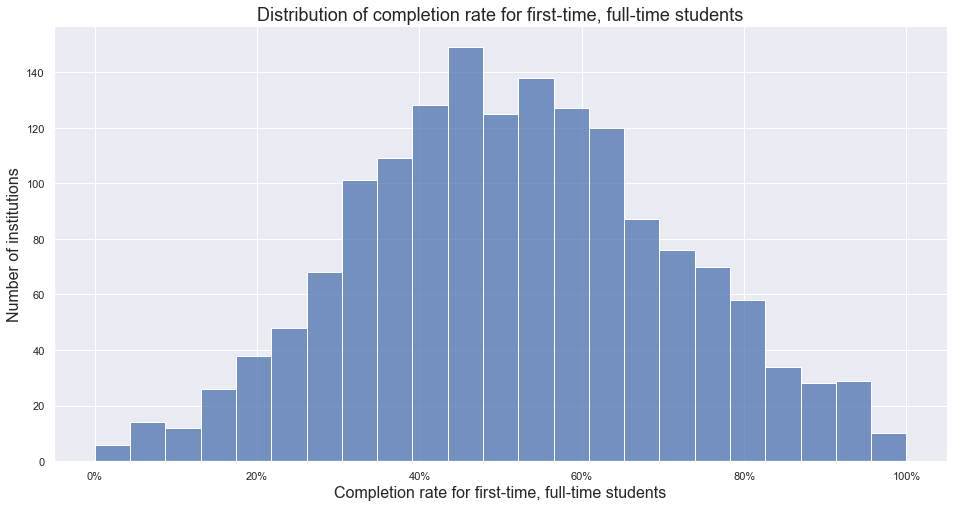

In [83]:
plt.figure(figsize=(16,8))
plot = sns.histplot(data=df, x='c150_4')
plot.xaxis.set_major_formatter(ticker.PercentFormatter())
plt.ylabel('Number of institutions',size=16)
plt.xlabel('Completion rate for first-time, full-time students',size=16)
plt.title('Distribution of completion rate for first-time, full-time students',size=18);

In [84]:
df[(df.c150_4 < np.mean(df['c150_4']) - 3 * np.std(df['c150_4'])) | \
   (df.c150_4 > np.mean(df['c150_4']) + 3 * np.std(df['c150_4']))]\
    [['instnm','unitid','c150_4','log_earnings']].sort_values(by='c150_4')

Empty DataFrame
Columns: [instnm, unitid, c150_4, log_earnings]
Index: []

The completion rate among first-time, full-time students in its linear form has a moderate and positive relationship with the log of median earnings feature. This feature follows a roughly normal distribution and no data were identified as outliers.


### Percent of students who received a Pell Grant at the institution and were still enrolled at original institution within 2 years

In [85]:
df['log_pell_enrl_orig_yr2_rt'] = np.log(df['pell_enrl_orig_yr2_rt'])

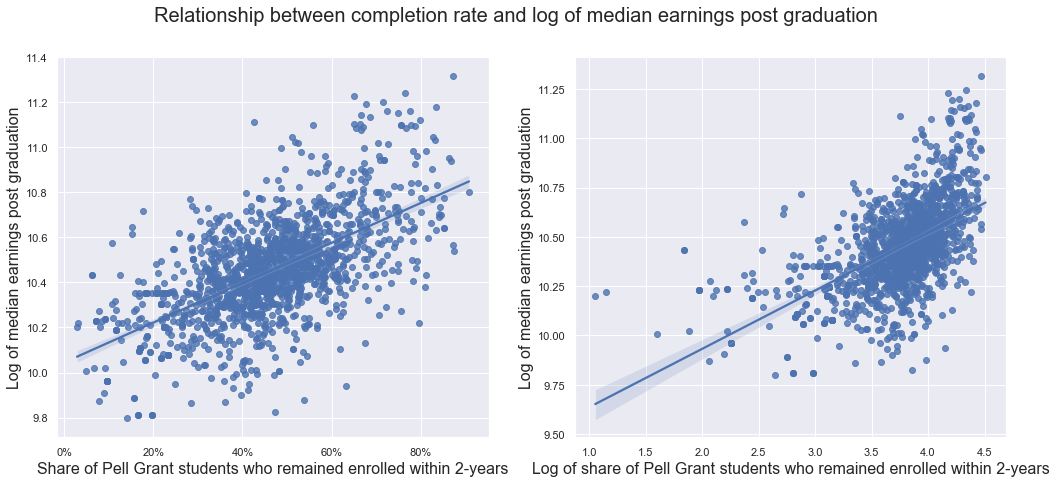

In [86]:
fig, axes = plt.subplots(1,2,figsize=(17,7))

ax0 = sns.regplot(data=df, x='pell_enrl_orig_yr2_rt', y='log_earnings', ax=axes[0])
ax0.xaxis.set_major_formatter(ticker.PercentFormatter())
ax0.set_ylabel('Log of median earnings post graduation', size = 16)
ax0.set_xlabel('Share of Pell Grant students who remained enrolled within 2-years', size = 16)

ax1 = sns.regplot(data=df, x='log_pell_enrl_orig_yr2_rt', 
                  y='log_earnings', ax=axes[1])
ax1.set_ylabel('Log of median earnings post graduation', size = 16)
ax1.set_xlabel('Log of share of Pell Grant students who remained enrolled within 2-years', size = 16)

fig.suptitle('Relationship between completion rate and log of median earnings post graduation',
             size =20);

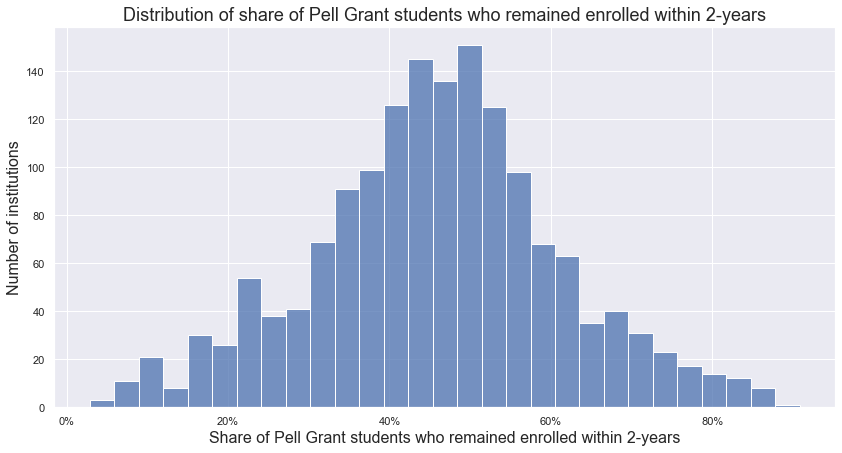

In [87]:
plt.figure(figsize=(14,7))
plot = sns.histplot(df['pell_enrl_orig_yr2_rt'])
plot.xaxis.set_major_formatter(ticker.PercentFormatter())
plt.ylabel('Number of institutions',size=16)
plt.xlabel('Share of Pell Grant students who remained enrolled within 2-years',size=16)
plt.title('Distribution of share of Pell Grant students who remained enrolled within 2-years',size=18);

The share of Pell Grant students who remained enrolled within 2-years appears to be roughly normally distributed and appears to have a moderate and positive relationship with the log of median earnings. As more students remain enrolled, the more successful these institutions may be at educating students, particularly students with higher financial students such as Pell Grant students. This feature will be included in the model.

### Create interaction terms of categorical and continuous features

Generate interaction terms between the indicators for whether an institution is public or private-non-profit institution, whether it has an open admissions policy, and whether it offers graduate programs or has high research activity based on the Carnegie Classification of higher education institutions.

In [88]:
df['public'] = df['control'].apply(lambda x: 1 if x == 1 else 0)

In [89]:
df['private_np'] = df['control'].apply(lambda x: 1 if x == 2 else 0)

In [90]:
for feature in ['satmtmid','log_faminc','pell_ever','log_avgfacsal','par_ed_pct_hs','dep_rpy_1yr_rt',
                'log_cdr2','med_earnings_growth','c150_4','pell_enrl_orig_yr2_rt']:
    df['open_'+feature] = df['openadmp'] * df[feature]
    df['public_'+feature] = df['public'] * df[feature]
    df['private_np_'+feature] = df['public'] * df[feature]
    df['high_research_and_grad_'+feature] = df['high_research_and_grad'] * df[feature]

In [91]:
features = ['satmtmid','log_faminc','pell_ever','log_avgfacsal','par_ed_pct_hs','openadmp','public',
    'private_np','high_research_and_grad','dep_rpy_1yr_rt','log_cdr2','med_earnings_growth','c150_4',
    'pell_enrl_orig_yr2_rt','open_satmtmid','public_satmtmid','private_np_satmtmid','high_research_and_grad_satmtmid',
    'open_log_faminc','public_log_faminc','private_np_log_faminc','high_research_and_grad_log_faminc','open_pell_ever',
    'public_pell_ever','private_np_pell_ever','high_research_and_grad_pell_ever','open_log_avgfacsal','public_log_avgfacsal',
    'private_np_log_avgfacsal','high_research_and_grad_log_avgfacsal','open_par_ed_pct_hs','public_par_ed_pct_hs',
    'private_np_par_ed_pct_hs','high_research_and_grad_par_ed_pct_hs','open_dep_rpy_1yr_rt','public_dep_rpy_1yr_rt',
    'private_np_dep_rpy_1yr_rt','high_research_and_grad_dep_rpy_1yr_rt','open_log_cdr2','public_log_cdr2',
    'private_np_log_cdr2','high_research_and_grad_log_cdr2','open_med_earnings_growth','public_med_earnings_growth',
    'private_np_med_earnings_growth','high_research_and_grad_med_earnings_growth','open_c150_4','public_c150_4',
    'private_np_c150_4','high_research_and_grad_c150_4','open_pell_enrl_orig_yr2_rt','public_pell_enrl_orig_yr2_rt',
    'private_np_pell_enrl_orig_yr2_rt','high_research_and_grad_pell_enrl_orig_yr2_rt']

### Missing data imputation

Use the existing data to impute missing data. Select the method that returns the highest R-squared score using cross validation. The methods tested below include:
* Simple median imputation
* K-nearest neighbor imputation
* Iterative imputation using the median as the initial strategy

The simple median imputation results in the highest R-squared score as is thus selected as the imputation method.

In [92]:
df.reset_index(inplace=True)

In [93]:
X = df[features]
y = df['log_earnings']

In [94]:
def get_scores(imputer, X, y):
    pipe = make_pipeline(imputer, LinearRegression(n_jobs=-1))
    
    return cross_val_score(pipe, X, y, cv = 5, n_jobs = -1)

In [95]:
def impute_median(X, y):
    
    imputer = SimpleImputer(missing_values=np.nan,
                            strategy='median')
    
    imputed_scores = get_scores(imputer, X, y)
    
    return imputed_scores.mean(), imputed_scores.std()

In [96]:
def impute_knn(X, y):
    
    imputer = KNNImputer(missing_values=np.nan,
                         n_neighbors = 3,
                         weights = 'distance')
    
    imputed_scores = get_scores(imputer, X, y)
    
    return imputed_scores.mean(), imputed_scores.std()

In [97]:
def impute_iter(X, y):
    
    imputer = IterativeImputer(missing_values=np.nan,
                               random_state=73,
                               initial_strategy='median')
    
    imputed_scores = get_scores(imputer, X, y)
    
    return imputed_scores.mean(), imputed_scores.std()

In [98]:
impute_median(X,y)

(0.6864417445097304, 0.05274254109725093)

In [99]:
impute_knn(X,y)

(0.6753263594088104, 0.06371248125807956)

In [100]:
impute_iter(X, y)

(0.00038153195004406724, 0.6591996196993714)

In [101]:
imputer = SimpleImputer(missing_values=np.nan,strategy='median')

X = pd.DataFrame(imputer.fit_transform(X),
                 columns = X.columns)

X.isnull().sum().sum(), y.isnull().sum()

(0, 0)

Select the most important predictors of median earnings using Lasso regression and regularization. First, determine the baseline performance of the null model.

#### Baseline performance

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [103]:
y_train_null = [np.mean(y_train)] * len(y_train)
y_test_null = [np.mean(y_test)] * len(y_test)

In [104]:
r2_score(y_train, y_train_null), r2_score(y_test, y_test_null)

(0.0, 2.220446049250313e-16)

In [105]:
mean_squared_error(y_train, y_train_null) ** .5, mean_squared_error(y_test, y_test_null) ** .5

(0.23774063146360278, 0.22340319195065472)

The null model has an R-squared of 0% and a root mean squared error above of .24 or less in both the training and testing data sets. The null model does not explain a high percentage of the variation in the log of the median earnings feature.

#### Lasso regression for feature selection

Apply a pipeline to find the optimal regularization parameter to run a Lasso regression and identify the most relevant features in the analysis data set including interacted features.

In [106]:
pipe = Pipeline([
    ('ss',StandardScaler()),
    ('lasso',Lasso())
])

params = {'ss__with_mean': [True, False], 
          'ss__with_std': [True, False],
          'lasso__alpha': np.logspace(-3,0,200)}

pipe_lr_cv = GridSearchCV(pipe,
                         params,
                         cv=3,
                         verbose=1,
                         n_jobs=-1)

In [107]:
pipe_lr_cv.fit(X,y)

Fitting 3 folds for each of 800 candidates, totalling 2400 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('lasso', Lasso())]),
             n_jobs=-1,
             param_grid={'lasso__alpha': array([0.001     , 0.00103532, 0.00107189, 0.00110975, 0.00114895,
       0.00118953, 0.00123155, 0.00127505, 0.00132009, 0.00136672,
       0.00141499, 0.00146497, 0.00151672, 0.00157029, 0.00162576,
       0.00168318, 0.00174263, 0.00180419, 0.00186791, 0.00193389,
       0.0...
       0.36543831, 0.37834626, 0.39171015, 0.40554607, 0.41987071,
       0.43470132, 0.45005577, 0.46595257, 0.48241087, 0.49945051,
       0.51709202, 0.53535667, 0.55426645, 0.57384416, 0.5941134 ,
       0.61509858, 0.63682499, 0.65931883, 0.68260718, 0.70671813,
       0.73168071, 0.75752503, 0.78428221, 0.8119845 , 0.84066529,
       0.87035914, 0.90110183, 0.9329304 , 0.96588322, 1.        ]),
                         'ss__with_mean': [True, False],
                         'ss__with_std': [True,

The highest R-squared score is 69.6% using a regularization strength of 0.0012.

In [108]:
pipe_lr_cv.best_score_

0.6923601984228397

In [109]:
pipe_lr_cv.best_params_

{'lasso__alpha': 0.0011895340673703195,
 'ss__with_mean': True,
 'ss__with_std': True}

In [110]:
pipe_lr_cv.best_estimator_

Pipeline(steps=[('ss', StandardScaler()),
                ('lasso', Lasso(alpha=0.0011895340673703195))])

In [111]:
Xs = pd.DataFrame(StandardScaler().fit_transform(X),
                  columns = X.columns)

Select the features that have a regression coefficient of at least 0.0232 and drop all other columns. This includes columns whose regression coefficients have been regularized to 0 using the penalty term in the Lasso regression.

In [112]:
coefs = pd.DataFrame(np.abs(Lasso(alpha = 0.0012).fit(Xs, y).coef_),
             pipe_lr_cv.feature_names_in_)
coefs.reset_index(inplace = True)
coefs.rename(columns = {'index':'feature', 0:'coef'}, inplace = True)
coefs = coefs.sort_values(by = 'coef', ascending = False)

In [113]:
pd.options.display.float_format = '{:.4f}'.format

In [114]:
coefs.head(9)

feature   coef
2                              pell_ever 0.0725
3                          log_avgfacsal 0.0703
11                   med_earnings_growth 0.0474
9                         dep_rpy_1yr_rt 0.0456
29  high_research_and_grad_log_avgfacsal 0.0447
35                 public_dep_rpy_1yr_rt 0.0331
39                       public_log_cdr2 0.0285
23                      public_pell_ever 0.0273
7                             private_np 0.0233

In [115]:
Xs.drop(columns=list(coefs[coefs['coef'] < 0.0232]['feature']), inplace=True)

The current data set contains 1,689 observations and 5 features.

In [116]:
Xs.shape

(1694, 9)

In [117]:
X = X[Xs.columns]

#### Implement principal component analysis to evaluate which components of the data explain its variation most

In [118]:
pca = PCA().fit(Xs)

The first five components of the data set explain over 90% of the variation in the data.

In [119]:
sum(pca.explained_variance_ratio_[:5])

0.9166935472104942

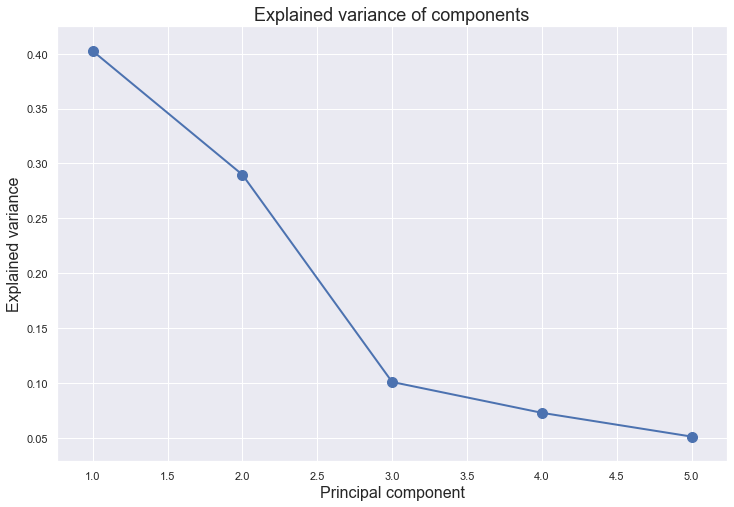

In [120]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(range(1,6), pca.explained_variance_ratio_[:5], lw=2)
ax.scatter(range(1, 6), pca.explained_variance_ratio_[:5], s=100)
ax.set_title('Explained variance of components', size = 18)
ax.set_xlabel('Principal component', size =16)
ax.set_ylabel('Explained variance', size=16);

plt.savefig('./assets/pca.png')

In [121]:
for weight,event  in zip(pca.components_[0], Xs.columns):
    print(event,":",weight)

pell_ever : 0.1754449135990284
log_avgfacsal : 0.13030628831538169
private_np : -0.44800266017173374
dep_rpy_1yr_rt : -0.04927844702943301
med_earnings_growth : 0.025148134209072658
public_pell_ever : 0.5106233011833466
high_research_and_grad_log_avgfacsal : 0.19340508163985265
public_dep_rpy_1yr_rt : 0.47615975683138234
public_log_cdr2 : 0.4728661339741942


The first principal component of the data explains over 40% of the variation in the data. This component reflects:
* Institutions higher shares of students who have received Pell Grants among all institution types and public institutions
* Higher values of the log of average montly faculty salary among all institution types and research intensive institutons and institutions with graduate programs
* Lower one-year repayment rates for dependent students
* Higher median earnings growth
* Higher one-year repayment rates for dependent students at public institutions
* Higher log of the two-year cohort default rate among public institutions

Create a data frame of PCA-transformed features.

In [122]:
pca_df = pd.DataFrame(pca.transform(Xs),
                      columns=['pr_comp_' + str(i) for i in range(Xs.shape[1])])

pca_df.head()

pr_comp_0  pr_comp_1  pr_comp_2  pr_comp_3  pr_comp_4  pr_comp_5  \
0     3.4455     2.2426    -1.2176     0.9422     1.0592     0.7742   
1     2.5205    -0.6110    -0.2561     0.7298     0.5303    -0.5110   
2     2.7683    -0.3852    -0.3883     0.2864     0.1514    -0.0928   
3     3.7828     2.5876    -0.7990     1.7330     1.3325     0.9974   
4     2.5304    -0.9685    -0.2698     0.1368     0.2410    -0.2532   

   pr_comp_6  pr_comp_7  pr_comp_8  
0    -0.7942     0.3453     0.2359  
1    -0.2978    -0.1129     0.1048  
2     0.0105    -0.0536     0.0495  
3    -0.9796     0.5203     0.2074  
4    -0.5119    -0.0399    -0.2272

Implement other models using and not using PCA including:
* Random forest regressor
* Extra-trees regressor
* Gradient boost regressor

In [123]:
score = cross_val_score(Ridge(),Xs,y,cv=5)

print("{} Score:\t{:0.2} ± {:0.2}".format('Ridge Regressor R-squared', score.mean(), 2 * score.std()))

Ridge Regressor R-squared Score:	0.68 ± 0.07


In [124]:
score = cross_val_score(RandomForestRegressor(n_estimators = 150,
                                              n_jobs = -1),X,y,cv=5)

print("{} Score:\t{:0.2} ± {:0.2}".format('Random Forest Regressor R-squared', score.mean(), 2 * score.std()))

Random Forest Regressor R-squared Score:	0.68 ± 0.074


In [125]:
score = cross_val_score(RandomForestRegressor(n_estimators = 150,n_jobs = -1),pca_df.iloc[:,:7],y,cv=5)

print("{} Score:\t{:0.2} ± {:0.2}".format('Random Forest Regressor R-squared (PCA)', score.mean(), 2 * score.std()))

Random Forest Regressor R-squared (PCA) Score:	0.68 ± 0.093


In [126]:
score = cross_val_score(ExtraTreesRegressor(n_estimators = 150,
                                            n_jobs=-1),X,y,cv=5)

print("{} Score:\t{:0.2} ± {:0.2}".format('Extra-trees Forest Regressor R-squared', score.mean(), 2 * score.std()))

Extra-trees Forest Regressor R-squared Score:	0.68 ± 0.072


In [127]:
score = cross_val_score(ExtraTreesRegressor(n_estimators = 150,n_jobs=-1),pca_df.iloc[:,:7],y,cv=5)

print("{} Score:\t{:0.2} ± {:0.2}".format('Extra-trees Forest Regressor R-squared (PCA)', score.mean(), 2 * score.std()))


Extra-trees Forest Regressor R-squared (PCA) Score:	0.68 ± 0.088


In [128]:
score = cross_val_score(GradientBoostingRegressor(n_estimators = 150),X,y,cv=5)

print("{} Score:\t{:0.2} ± {:0.2}".format('Gradient Boosting Regressor R-squared', score.mean(), 2 * score.std()))

Gradient Boosting Regressor R-squared Score:	0.69 ± 0.065


In [129]:
score = cross_val_score(GradientBoostingRegressor(n_estimators = 150),pca_df.iloc[:,:7],y,cv=5)

print("{} Score:\t{:0.2} ± {:0.2}".format('Gradient Boosting Regressor R-squared (PCA)', score.mean(), 2 * score.std()))

Gradient Boosting Regressor R-squared (PCA) Score:	0.68 ± 0.091


In [130]:
gb = GradientBoostingRegressor().fit(X,y)

Using the Gradient Booster Regressor feature importances attribute, it can be concluded that the most important features in the prediction of median earnings are:
* Share of Pell Grant students
* Log of average monthly faculty salary
* One-year dependent student repayment rate
* Median earnings growth
* Log of average monthly faculty at research intensive institutions

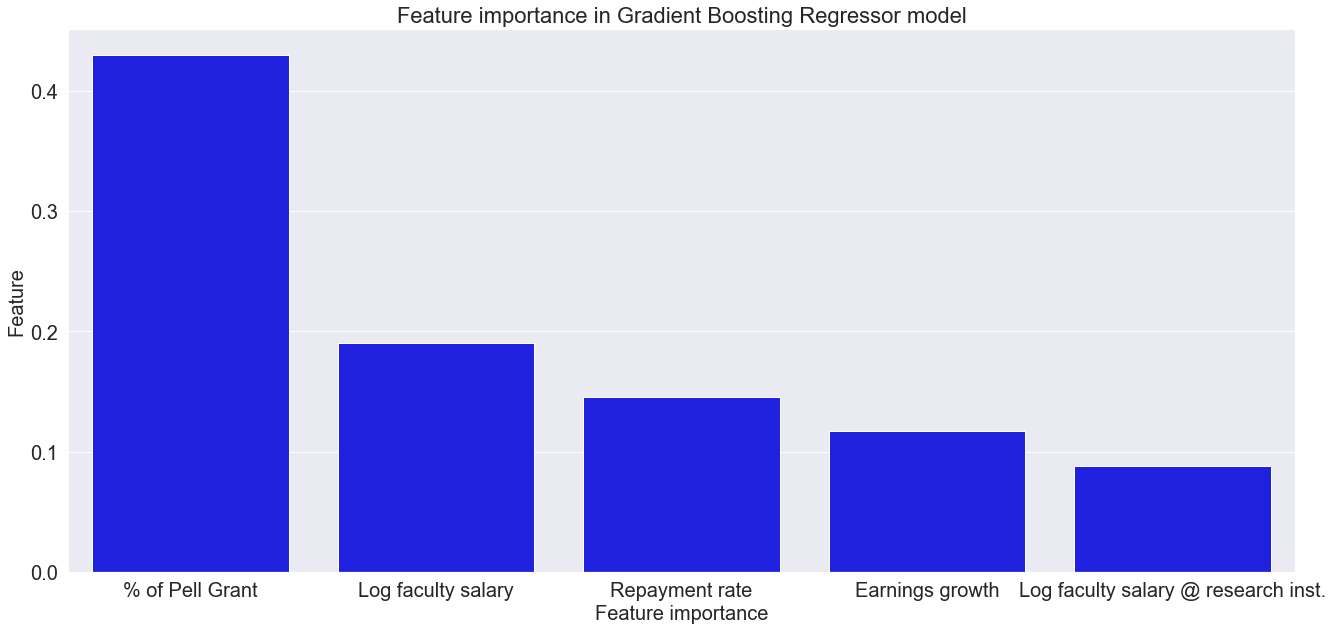

In [131]:
feat_imp = pd.DataFrame(list(zip(gb.feature_names_in_,gb.feature_importances_)),
                        columns = ['feature','importance'])

feat_imp = feat_imp[feat_imp['importance'] >= 0.08]
plt.figure(figsize = (22,10))
plot = sns.barplot(data = feat_imp.sort_values(by = 'importance', ascending = False),
               x = 'feature',y = 'importance', color = 'blue')

labels = ['% of Pell Grant','Log faculty salary',
         'Repayment rate','Earnings growth',
         'Log faculty salary @ research inst.']

plot.set_xticklabels(labels,rotation = 0,size=20)
plt.yticks(fontsize=20)
plt.xlabel('Feature importance', size=20)
plt.ylabel('Feature', size=20)
plt.title('Feature importance in Gradient Boosting Regressor model', size=22);
plt.savefig('./assets/featimp.png')

### Model Evaluation

Select the model with the lowest root mean squared error and the highest R-squared score. Create a function to evaluate these two metrics.

In [132]:
model_evaluations = []

In [133]:
def model_evaluation(explanatory_features,estimator,estimator_name,y=y):
    y_preds = estimator.fit(explanatory_features,y).predict(explanatory_features)
    
    return model_evaluations.append((estimator_name,
                              cross_val_score(estimator,explanatory_features,y,cv=5,scoring='r2').mean(),
                              '±' + str(round(2 * cross_val_score(estimator,explanatory_features,y,cv=5,
                                              scoring='neg_mean_squared_error').std(),4))))

In [134]:
model_evaluation(Xs,LinearRegression(),'Multiple linear regression')

In [135]:
model_evaluation(Xs,Lasso(alpha=0.0014),'Lasso')

In [136]:
model_evaluation(Xs,Ridge(),'Ridge regression')

In [137]:
model_evaluation(X,RandomForestRegressor(n_estimators = 150,n_jobs = -1),'Random forest regressor')

In [138]:
model_evaluation(X,ExtraTreesRegressor(n_estimators = 150,n_jobs = -1),'Extra-trees regressor')

In [139]:
model_evaluation(X,GradientBoostingRegressor(n_estimators = 150),'Gradient boost regressor')

In [140]:
model_evaluations = pd.DataFrame({'Model':[val[0] for val in model_evaluations],
                        'Mean R-squared':[val[1] for val in model_evaluations],
                        '2 Standard deviations from mean R-squared':[val[2] for val in model_evaluations]})
model_evaluations

Model  Mean R-squared  \
0  Multiple linear regression          0.6844   
1                       Lasso          0.6811   
2            Ridge regression          0.6845   
3     Random forest regressor          0.6885   
4       Extra-trees regressor          0.6823   
5    Gradient boost regressor          0.6930   

  2 Standard deviations from mean R-squared  
0                                    ±0.007  
1                                   ±0.0076  
2                                    ±0.007  
3                                   ±0.0062  
4                                    ±0.007  
5                                   ±0.0064

The best model is the extra trees regressor without PCA based on the highest R-squared and lowest two standard deviation range of the mean R-squared using cross validation.

Plot the log of median earnings and its predicted value to visualize how well the model predicts the target.

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

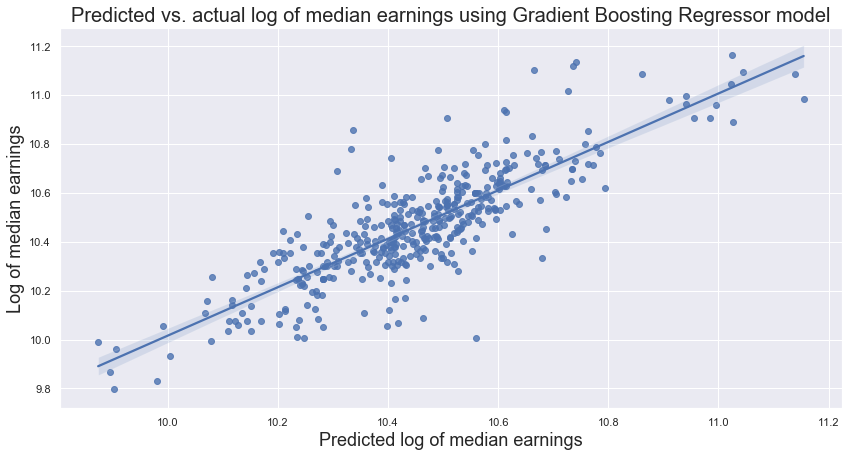

In [142]:
plt.figure(figsize=(14,7))
sns.regplot(x = GradientBoostingRegressor().fit(X_train,y_train).predict(X_test),
            y = y_test)
plt.xlabel('Predicted log of median earnings',size=18)
plt.ylabel('Log of median earnings',size=18)
plt.title('Predicted vs. actual log of median earnings using Gradient Boosting Regressor model',size=20);
plt.savefig('./assets/preds.png')

Overall, the model performs moderately in predicting the target. Some of the largest errors appear to be between log of median earnings less than 10.2 with predicted values of over 10.4 or with predicted values of less than 10.8 but with actual values of 11.2. However, the correlation between both predicted and actual values is moderate to high at almost 84%.

In [143]:
y_preds = GradientBoostingRegressor().fit(X_train,y_train).predict(X_test)

In [144]:
np.corrcoef(y_preds,y_test)

array([[1.        , 0.83148688],
       [0.83148688, 1.        ]])

### Model interpretation

Fit a linear regression model using the features that were identified by the Gradient Boosting Regressor model as the most important features and interpret their coefficients.

In [145]:
X_ols = sm.add_constant(Xs)

In [146]:
ols_results = sm.OLS(y, X_ols).fit()

In [147]:
print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:           log_earnings   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     453.5
Date:                Sun, 24 Apr 2022   Prob (F-statistic):               0.00
Time:                        20:49:12   Log-Likelihood:                 1093.1
No. Observations:                1694   AIC:                            -2166.
Df Residuals:                    1684   BIC:                            -2112.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


All features reported by the regression output have a statistically significant relationship with the log of median earnings based on the p-value having a significance level below 0.05. 

The coefficient of linear features will be converted to percentage terms by exponentiating it and subtracting from one and multiplying by 100. The coefficient of logged variables will be interpreted as the percentage change in median earnings given a percentage change in the feature.

Interpretation of relationship of linear features to log of median earnings:
* As the share of students who have received Pell grants, the median earnings post graduation decrease by 7.3% (calculated as 100*(np.exp(-0.0761) - 1))
* The median earnings of private non-profit institutions are 3.54% lower compared to the median earnings of other institutions
* As the one-year repayment rate among dependent students increases by one unit, the median earnings increase by approximately 4.9%
* As the median earnings growth between academic years 2003-2004 and 2013-2014 increases by one unit, the median earnings increase by 6%
* A higher share of Pell grant students among public institutions increases median earnings by approximately 5%. For public institutions, the net effect of one unit increase in the share of Pell grant students on median earnings is a decrease of around 2.1% (7.3% - 5.2%)
* A one unit increase in the one year repayment rate among dependent students for public institutions, on average, increases decreases median earnings by 5.5%. The net effect of an additional increase in the repayment rate for public institutions is around a .6% reduction in median earnings (4.9%-5.5%)

Interpretation of relationship of logged features to log of median earnings:
* A one percentage increase in the average monthly faculty salary is associated with a 7.4% increase in median earnings and 3.3% among research intensive institutions
* A one percent increase in the two-year cohort default rate among public institutions is associated with a 5.4% decrease in median earnings

### Conclusion

Higher education administrators and state education agencies must consider policy changes aimed at increasing access to higher education for underserved communities. Policy options that are available include implementing an open admissions policy and increasing the share of students who have ever received a Pell Grant. This analysis found that having an open admissions policy is not a strong predictor of median earnings post graduation, an accountability measure to evaluate the effectiveness of higher education institutions in matching graduates to high quality jobs.

Using data from the U.S. Department of Education's College Scorecard, this analysis found that an increase in the share of students who have ever received a Pell Grant is associated with a 7.3% decrease in median earnings and 2.1% decrease for public institutions. This should not discourage higher education administrators from enrolling students with high financial need, or Pell Grant students, but rather should encourage them to recognize that the challenge of supporting these students in obtaining high paying jobs may require more academic and non-academic supports to ensure any opportunity gaps are closed for these students. 

Among all institutions, the one-year repayment rate for dependent students is a strong predictor of median earnings post graduation. A one unit increase in this rate is associated with a 4.9% increase in median earnings a slight 0.6% reduction for public institutions. This information can help higher education administrators monitor the economic outcomes of students over time and analyze data of students lagging behind in earnings outcomes to understand what added supports may be necessary for students to achieve better outcomes. Sustaining improvements in student outcomes over time can be expected to result in improvements in median earnings. A one percentage increase in the median earnings growth in a 10-year period is associated with a 6% increase in median earnings. 

Worse financial outcomes are also red flags that higher education admnistrators and state education agencies should pay attention to. Higher two-year cohort educational loan default rates are associated with a 5.4% reduction in median earnings. On average, a percentage increase in average monthly faculty salaries is associated with a 7.4% median earnings. This may reflect the fact that some of the institutions with higher resources may enroll students with higher family incomes, who are more likely to have higher earnings themselves.

The model created in this analysis predicted median earnings six years post graduation by explaining around 70% of the variation in this feature. This model can be used to generate debate and conversation institutional and across institutions about what policy changes and red flags should be considered when evaluating their effect on important student outcomes such as earnings post graduation. 

### Pickle the data needed for the Gradient Boosting model for use in a flask app to visualize the effect of policy changes.

In [182]:
df_flask = X.merge(y,how='left',left_index=True,right_index=True).merge(df[['instnm','public',
                                                                            'high_research_and_grad','cdr2',
                                                                            'md_earn_wne_p6','avgfacsal']],
                                                                            how='left',
                                                                            left_index=True,
                                                                            right_index=True)

In [183]:
with open('./app/data.pkl', 'wb') as picklefile:
    pickle.dump(df_flask, picklefile)

### References:
* [Missing data imputation methods GA lecture by Sophie Tabac](https://git.generalassemb.ly/dsi-andromeda/missing-data-ii)
* [Plotly documentation on Chrolopleth maps](https://plotly.com/python/choropleth-maps/)
* [Matplotlib documentation on color palettes](https://matplotlib.org/3.5.1/tutorials/colors/colors.html)
* [Interpretations of log-linear regression models](https://data.library.virginia.edu/interpreting-log-transformations-in-a-linear-model/#:~:text=Interpret%20the%20coefficient%20as%20the,x%20percent%20increase%2C%20calculate%201.)
* [The Value of Using Early-Career Earnings Data
in the College Scorecard to Guide College Choices](https://deliverypdf.ssrn.com/delivery.php?ID=822120120111025007089071067007091101052045036029007018028086110122126085069021086096017052125052057022012004124089071100119025118059005053080003030011012125084077077046060031115120064085025121092096003087003028120092028095079122115079022104082029080093&EXT=pdf&INDEX=TRUE)
* [Feature Selection of Post-Graduation Income of College
Students in the United States](https://arxiv.org/pdf/1803.06615.pdf)
* [Matplotlib xtick formatter](https://matplotlib.org/3.4.3/gallery/ticks_and_spines/tick-formatters.html)